# SLAMseq

## Installing slamdunk (only do once)

In [ ]:
# install slamdunk (recommended BUT SEE BELOW)
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

# I forked it
# git clone git://github.com/monikaperez/slamdunk.git
# pip install -e slamdunk

In [ ]:
# please also install cutadapt, fastqc, trimgalore, and varscan
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore
#! conda install -c bioconda varscan

colorcet had to be installed (add as dependency)

In [2]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna
import warnings

from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# Renaming dirs and files

* directory = slamseq_MYB_degraded_v1
* files = MYB_degraded_v1

In [696]:
project_old = project
project_new = project_old.replace("_YKL", "")
print(project_old, project_new)

MYB_degraded_YKL_v1 MYB_degraded_v1


In [704]:
rename = {}
rename[project_old] = project_new
rename

{'MYB_degraded_YKL_v1': 'MYB_degraded_v1'}

In [730]:
dir_new = "slamseq_"+project.replace("_YKL", "")
dir_new

'slamseq_MYB_degraded_v1'

In [757]:
data_dir = "../results/"+dir_new+"/plots"
data_dir

'../results/slamseq_MYB_degraded_v1/plots'

In [760]:
plot_files = ! ls $data_dir
plot_files

['MYB_degraded_YKL_v1_ERCCsamplewise_0_5_DESeq_results_of_MV411_under_MYB_degraded_YKL_volcano.html',
 'MYB_degraded_YKL_v1_scaling_fact_with_conf.pdf',
 'MYB_degraded_YKL_v1_similarity_replicates_sorted.pdf',
 'MYB_degraded_YKL_v1_similarity_replicates_sorted_readcounts.pdf',
 'MYB_degraded_YKL_v1_similarity_replicates_sorted_tccounts.pdf']

In [763]:
# rename data dir locally
for rep_old in plot_files:
    for old, new in rename.items():
        rep_new = rep_old.replace(old, new)
    print(rep_old+" : "+rep_new)
    if (rep_old != rep_new) & (os.path.exists(data_dir+"/"+rep_old)):
        ! mv $data_dir/$rep_old $data_dir/$rep_new

MYB_degraded_YKL_v1_ERCCsamplewise_0_5_DESeq_results_of_MV411_under_MYB_degraded_YKL_volcano.html : MYB_degraded_v1_ERCCsamplewise_0_5_DESeq_results_of_MV411_under_MYB_degraded_YKL_volcano.html
MYB_degraded_YKL_v1_scaling_fact_with_conf.pdf : MYB_degraded_v1_scaling_fact_with_conf.pdf
MYB_degraded_YKL_v1_similarity_replicates_sorted.pdf : MYB_degraded_v1_similarity_replicates_sorted.pdf
MYB_degraded_YKL_v1_similarity_replicates_sorted_readcounts.pdf : MYB_degraded_v1_similarity_replicates_sorted_readcounts.pdf
MYB_degraded_YKL_v1_similarity_replicates_sorted_tccounts.pdf : MYB_degraded_v1_similarity_replicates_sorted_tccounts.pdf


# MYB degraded (MYC-dTAG) with spikeIn

## Downloading the data

In [2]:
#version="vAll"
project = "MYB_degraded_v1"
location = "../data/"+"slamseq_"+project+"/" # new data location
loc = "210722_MP9119_fastq" # transfer AML folder

In [71]:
! gsutil ls gs://transfer-amlproject/$loc/

gs://transfer-amlproject/210722_MP9119_fastq/._multiqc_report.html
gs://transfer-amlproject/210722_MP9119_fastq/20210722_10_MP9119_S95_R1_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_10_MP9119_S95_R2_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_11_MP9119_S96_R1_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_11_MP9119_S96_R2_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_12_MP9119_S97_R1_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_12_MP9119_S97_R2_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_1_MP9119_S86_R1_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_1_MP9119_S86_R2_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_2_MP9119_S87_R1_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_2_MP9119_S87_R2_001.fastq.gz
gs://transfer-amlproject/210722_MP9119_fastq/20210722_3_MP9119_S88_R1_001.fastq.gz
gs://transfer-

In [77]:
mkdir ../data/slamseq_$project/ && mkdir ../data/slamseq_$project/qc # make data dir in AMLproject

In [78]:
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html ../data/slamseq_$project/qc/ # transfer qc files
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ ../data/slamseq_$project/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ ../data/slamseq_$project/qc/

Copying gs://transfer-amlproject/210722_MP9119_fastq/multiqc_report.html...
/ [1/1 files][  1.3 MiB/  1.3 MiB] 100% Done                                    
Operation completed over 1 objects/1.3 MiB.                                      
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R1_001_fastqc.html...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R2_001_fastqc.html...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_10_MP9119_S95_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_11_MP9119_S96_R1_001_fastqc.html...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_11_MP9119_S96_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/210722_MP9119_fastq/Reports/20210722_11_MP9119_S96_R2_001_fastqc.html...
Copying gs://transfer-

In [51]:
# make dir in /home/monika/data/project/fastqs
mkdir ../../data/slamseq_$project/ && mkdir ../../data/slamseq_$project/fastqs/

In [52]:
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../../data/slamseq_$project/fastqs/ # transfer fastqs

Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_10_MP9119_S95_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_10_MP9119_S95_R2_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_11_MP9119_S96_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_11_MP9119_S96_R2_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_12_MP9119_S97_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_12_MP9119_S97_R2_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_1_MP9119_S86_R1_001.fastq.gz...
Copying gs://transfer-amlproject/210722_MP9119_fastq/20210722_1_MP9119_S86_R2_0

In [61]:
fastq = ! ls ../../data/slamseq_$project/fastqs

In [62]:
ls ../../data/slamseq_$project/fastqs

20210722_10_MP9119_S95_R1_001.fastq.gz  20210722_4_MP9119_S89_R1_001.fastq.gz
20210722_10_MP9119_S95_R2_001.fastq.gz  20210722_4_MP9119_S89_R2_001.fastq.gz
20210722_11_MP9119_S96_R1_001.fastq.gz  20210722_5_MP9119_S90_R1_001.fastq.gz
20210722_11_MP9119_S96_R2_001.fastq.gz  20210722_5_MP9119_S90_R2_001.fastq.gz
20210722_12_MP9119_S97_R1_001.fastq.gz  20210722_6_MP9119_S91_R1_001.fastq.gz
20210722_12_MP9119_S97_R2_001.fastq.gz  20210722_6_MP9119_S91_R2_001.fastq.gz
20210722_1_MP9119_S86_R1_001.fastq.gz   20210722_7_MP9119_S92_R1_001.fastq.gz
20210722_1_MP9119_S86_R2_001.fastq.gz   20210722_7_MP9119_S92_R2_001.fastq.gz
20210722_2_MP9119_S87_R1_001.fastq.gz   20210722_8_MP9119_S93_R1_001.fastq.gz
20210722_2_MP9119_S87_R2_001.fastq.gz   20210722_8_MP9119_S93_R2_001.fastq.gz
20210722_3_MP9119_S88_R1_001.fastq.gz   20210722_9_MP9119_S94_R1_001.fastq.gz
20210722_3_MP9119_S88_R2_001.fastq.gz   20210722_9_MP9119_S94_R2_001.fastq.gz


In [3]:
from natsort import os_sorted
os_sorted(fastq[::2])

NameError: name 'fastq' is not defined

In [34]:
mkdir ../results/slamseq_$project/

Rename fastqs

In [ ]:
#if need to download the data from sra
#! mkdir ../../data/slam/MYCpaper && cd ../../data/slam/MYCpaper && fastq_dump SRR5806781 && fastq_dump SRR5806783 && fastq_dump SRR5806785 &&
#fastq_dump SRR5806780 && fastq_dump SRR5806782 && fastq_dump SRR5806784 && cd -

In [91]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
print(fastq_folder)
fastq = ! ls $fastq_folder
fastq

../../data/MYB_degraded_YKL_v1/fastqs


['20210722_10_MP9119_S95_R1_001.fastq.gz',
 '20210722_10_MP9119_S95_R2_001.fastq.gz',
 '20210722_11_MP9119_S96_R1_001.fastq.gz',
 '20210722_11_MP9119_S96_R2_001.fastq.gz',
 '20210722_12_MP9119_S97_R1_001.fastq.gz',
 '20210722_12_MP9119_S97_R2_001.fastq.gz',
 '20210722_1_MP9119_S86_R1_001.fastq.gz',
 '20210722_1_MP9119_S86_R2_001.fastq.gz',
 '20210722_2_MP9119_S87_R1_001.fastq.gz',
 '20210722_2_MP9119_S87_R2_001.fastq.gz',
 '20210722_3_MP9119_S88_R1_001.fastq.gz',
 '20210722_3_MP9119_S88_R2_001.fastq.gz',
 '20210722_4_MP9119_S89_R1_001.fastq.gz',
 '20210722_4_MP9119_S89_R2_001.fastq.gz',
 '20210722_5_MP9119_S90_R1_001.fastq.gz',
 '20210722_5_MP9119_S90_R2_001.fastq.gz',
 '20210722_6_MP9119_S91_R1_001.fastq.gz',
 '20210722_6_MP9119_S91_R2_001.fastq.gz',
 '20210722_7_MP9119_S92_R1_001.fastq.gz',
 '20210722_7_MP9119_S92_R2_001.fastq.gz',
 '20210722_8_MP9119_S93_R1_001.fastq.gz',
 '20210722_8_MP9119_S93_R2_001.fastq.gz',
 '20210722_9_MP9119_S94_R1_001.fastq.gz',
 '20210722_9_MP9119_S94_R2_0

In [97]:
# copy from AML sample tracker - RNA_tracker_JK
rename = {
    "20210722_1_MP9119_S86": "mr359-MV411-MYB-dTAG-DMSO_1h-r1",
    "20210722_2_MP9119_S87": "mr360-MV411-MYB-dTAG-DMSO_1h-r2",
    "20210722_3_MP9119_S88": "mr361-MV411-MYB-dTAG-DMSO_1h-r3",
    "20210722_4_MP9119_S89": "mr362-MV411-MYB-dTAG-DMSO_1h-r4",
    "20210722_5_MP9119_S90": "mr363-MV411-MYB-dTAG-DMSO_1h-r5",
    "20210722_6_MP9119_S91": "mr364-MV411-MYB-dTAG-DMSO_1h-r6",
    
    "20210722_7_MP9119_S92": "mr365-MV411-MYB-dTAG-VHL_1h-r1",
    "20210722_8_MP9119_S93": "mr366-MV411-MYB-dTAG-VHL_1h-r2",
    "20210722_9_MP9119_S94": "mr367-MV411-MYB-dTAG-VHL_1h-r3",
    "20210722_10_MP9119_S95": "mr368-MV411-MYB-dTAG-VHL_1h-r4",
    "20210722_11_MP9119_S96": "mr369-MV411-MYB-dTAG-VHL_1h-r5",
    "20210722_12_MP9119_S97": "mr370-MV411-MYB-dTAG-VHL_1h-r6"
}

In [106]:
# rename fastqs locally
for val in fastq:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

In [117]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastq_full = [fastq_folder+"/"+f for f in fastq]
fastq_full

['../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001.fastq.gz',
 '../../da

## SLAMDUNK

install slamdunk & dependencies if needed (see above)

In [ ]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore
#! conda install -c varscan
#! also install ngm

### running trim galore

In [120]:
for val1, val2 in h.grouped(fastq_full, 2):
    print(val1)
    print(val2)
    print("\n")

../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz
../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz


../../data/MYB_degraded_YKL_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz
../../data/MYB_degraded_YKL_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz


../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz
../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001.fastq.gz


../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001.fastq.gz
../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001.fastq.gz


../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001.fastq.gz
../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001.fastq.gz


../../data/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001.fastq.gz
../../data/MYB_degraded_YKL_v1/fastqs/mr364-

In [144]:
#h.parrun(['trim_galore --paired --cores 14 --retain_unpaired -stringency 3\
# --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastq_full,2)], 2)

download reference genome files

In [147]:
ref_folder = "../../ref"

In [154]:
# google storage bucket with reference files
! gsutil ls gs://ccle_default_params/

gs://ccle_default_params/3UTRs.bed
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf.idx
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters.json
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters_light.json
gs://ccle_default_params/CNV_and_centromere_blacklist.hg38liftover.list
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bai
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bam
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta.fai
gs://ccle_default_params/STAR_genome_GRCh38_noALT_noHLA_noDecoy_ERCC_v29_oh100.tar.gz
gs://ccle_default_params/allknown_mutatio

In [149]:
# copy reference genome files
! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

Copying gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm...
Copying gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm...
Copying gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta.fai...    
\ [4/4 files][  8.6 GiB/  8.6 GiB] 100% Done     0.0 B/s                        
Operation completed over 4 objects/8.6 GiB.                                      


In [188]:
# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

In [155]:
! mv ../../data/slamseq_$project/fastqs/*.fastq.gz ../../data/slamseq_$project/fastqs_renamed/

In [157]:
ls -al ../../data/slamseq_$project/fastqs

total 63619592
drwxr-xr-x 2 monika monika      12288 Jul 30 21:43 ./
drwxr-xr-x 4 monika monika       4096 Jul 30 18:47 ../
-rw-r--r-- 1 monika monika       5738 Jul 30 14:57 mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt
-rw-r--r-- 1 monika monika    3257458 Jul 30 15:23 mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_unpaired_1.fq.gz
-rw-r--r-- 1 monika monika 2886942191 Jul 30 15:23 mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
-rw-r--r-- 1 monika monika       5860 Jul 30 15:23 mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz_trimming_report.txt
-rw-r--r-- 1 monika monika    4023915 Jul 30 15:23 mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_unpaired_2.fq.gz
-rw-r--r-- 1 monika monika 2975473977 Jul 30 15:23 mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz
-rw-r--r-- 1 monika monika       5710 Jul 30 14:56 mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz_trimming_report.txt
-rw-r--r-- 1 monika monika    2489614 Jul 30 15:22 mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_unpaired_1.

In [189]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome="../../ref/Homo_sapiens_assembly38_ERCC92.fasta"

In [190]:
ls ../../ref/

ERCC92.fa
ERCC92.gtf
GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed
hg38_ERCC92.gtf
Homo_sapiens_assembly38_ERCC92.fasta
Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
Homo_sapiens_assembly38_ERCC92.fasta.fai
Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
Homo_sapiens_assembly38.fasta.gz
reference_droso.fna


In [196]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

In [214]:
for val1, val2 in h.grouped(fastq_full[:2], 2):
    print(os.path.basename(val1))
    #print(val1.split('/')[-1].split('_R')[0])
    #print(val1.replace('.fastq.gz','_val_1.fq.gz'))
    print('slamdunk all -r '+refgenome+' -b '+gene_intervals+' -o ../../data/'+"slamseq_"+project+
          '/res/ -t 14 -c 2 -N '+
          val1.split('/')[-1].split('_R')[0]+' '+val1.replace('.fastq.gz','_val_1.fq.gz')+
          " "+val2.replace('.fastq.gz','_val_2.fq.gz'))
    print("\n")

mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz
slamdunk all -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -o ../../data/MYB_degraded_YKL_v1/res/ -t 14 -c 2 -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz


Completed in 0:00:00.001225


In [206]:
fastq_full

['../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001.fastq.gz',
 '../../data/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001.fastq.gz',
 '../../da

### running slamdunk

__use res_v4__
<br>res_v1 = initial slamdunk all run
 - snp_old: .vcf files empty
 - snp: vcf files filled

<br>res_v2 = manual slamdunk map run on mr359-MV411-MYB-dTAG-DMSO_1h-r1
<br>res_v3 = slamdunk all on mr359-MV411-MYB-dTAG-DMSO_1h-r1
<br>res_v4 = slamdunk all w/ max-read-length = 152 (-rl 152)

res_v1

In [215]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -r '+refgenome+
          ' -b '+gene_intervals+
          ' -o ../../data/'+"slamseq_"+project+'/res_v4/'+
          ' -t 14'+
          ' -c 2'+
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1.replace('.fastq.gz','_val_1.fq.gz')+" "+val2.replace('.fastq.gz','_val_2.fq.gz')
          for val1, val2 in h.grouped(fastq_full, 2)], 2)


Completed in 0:00:02.938737


__res_v4__

In [22]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)
        
#createDir('../../data/'+project+'/res_v4/map')
#os.path.join('../../data/'+project, "map")

In [505]:
list(h.grouped(fastq_full[4:], 2))

[('../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001.fastq.gz',
  '../../data/MYB_degraded_YKL_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001.fastq.gz'),
 ('../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001.fastq.gz',
  '../../data/MYB_degraded_YKL_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001.fastq.gz'),
 ('../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001.fastq.gz',
  '../../data/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001.fastq.gz'),
 ('../../data/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001.fastq.gz',
  '../../data/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R2_001.fastq.gz'),
 ('../../data/MYB_degraded_YKL_v1/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R1_001.fastq.gz',
  '../../data/MYB_degraded_YKL_v1/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R2_001.fastq.gz'),
 ('../../data/MYB_degraded_YKL_v1/fastqs/mr366-MV411-MYB-dTAG-VHL_1h-r2_R1_001.fastq.gz

In [489]:
%%time

print(['slamdunk all'+
       ' -o '+"../../data/"+"slamseq_"+project+"/res_v4/"+
       ' -r '+refgenome+
       ' -b '+gene_intervals+
       ' -c 2'+
       ' -t 14'+
       ' -rl 152'+ # max-read-length = 152
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1.replace('.fastq.gz','_val_1.fq.gz')+" "+val2.replace('.fastq.gz','_val_2.fq.gz')
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/MYB_degraded_YKL_v1/res_v4/ -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -c 2 -t 14 -rl 152 -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 166 µs


In [501]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o ../../data/'+"slamseq_"+project+'/res_v4/'+
          ' -r '+refgenome+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1.replace('.fastq.gz','_val_1.fq.gz')+" "+val2.replace('.fastq.gz','_val_2.fq.gz')
          for val1, val2 in h.grouped(fastq_full[2:4], 2)], 2)

CPU times: user 236 ms, sys: 84 ms, total: 320 ms
Wall time: 2h 14min 40s


In [506]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o ../../data/'+"slamseq_"+project+'/res_v4/'+
          ' -r '+refgenome+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1.replace('.fastq.gz','_val_1.fq.gz')+" "+val2.replace('.fastq.gz','_val_2.fq.gz')
          for val1, val2 in h.grouped(fastq_full[4:], 2)], 2)

CPU times: user 1.96 s, sys: 808 ms, total: 2.77 s
Wall time: 19h 36min 10s


Rerunning slamdunk step by step

slamdunk all 
-r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta 
-b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed 
-o ../../data/MYB_degraded_YKL_v1/res/ 
-t 14 
-c 2 
-N mr359-MV411-MYB-dTAG-DMSO_1h-r1 
../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz

slamdunk map fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o res/map/ -t 14 |& tee res/map/mr359_mapped.log

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)


In [479]:
%%time

# map
print(['slamdunk map '+
       val1.replace('.fastq.gz','_val_1.fq.gz')+" "+val2.replace('.fastq.gz','_val_2.fq.gz')+
       " -N "+val1.split('/')[-1].split('_R')[0]+
       ' -r '+refgenome+
       ' -o ../../data/'+"slamseq_"+project+'/res/map/'+
       ' -t 14'])

['slamdunk map ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o ../../data/MYB_degraded_YKL_v1/res/map/ -t 14']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 183 µs


In [476]:
val1.split('/')[-1].split('_R')[0]

'mr359-MV411-MYB-dTAG-DMSO_1h-r1'

Rerun slamdunk snp

In [425]:
%%time

# rerun slamdunk snp with mapped & filtered bams
h.parrun(['slamdunk snp'+
          ' -r '+refgenome+
          ' -o ../../data/'+"slamseq_"+project+'/res/snp'+
          ' -t 14 '+
          '../../data/'+project+'/res/filter/'+val1.split('/')[-1].split('_R')[0]+"_filtered.bam"
          for val1, val2 in h.grouped(fastq_full[2:], 2)], 2)

CPU times: user 384 ms, sys: 220 ms, total: 604 ms
Wall time: 3h 35min 21s


In [478]:
%%time

print(['slamdunk snp'+
      ' -r '+refgenome+
      ' -o ../../data/'+"slamseq_"+project+'/res/snp/'+
      ' -t 14 '+
      '../../data/'+project+'/res/filter/'+val1.split('/')[-1].split('_R')[0]+"_filtered.bam" for val1,val2 in h.grouped(fastq_full[2:], 2)])

['slamdunk snp -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o ../../data/MYB_degraded_YKL_v1/res/snp/ -t 14 ../../data/MYB_degraded_YKL_v1/res/filter/mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam', 'slamdunk snp -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o ../../data/MYB_degraded_YKL_v1/res/snp/ -t 14 ../../data/MYB_degraded_YKL_v1/res/filter/mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam', 'slamdunk snp -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o ../../data/MYB_degraded_YKL_v1/res/snp/ -t 14 ../../data/MYB_degraded_YKL_v1/res/filter/mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam', 'slamdunk snp -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o ../../data/MYB_degraded_YKL_v1/res/snp/ -t 14 ../../data/MYB_degraded_YKL_v1/res/filter/mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam', 'slamdunk snp -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -o ../../data/MYB_degraded_YKL_v1/res/snp/ -t 14 ../../data/MYB_degraded_YKL_v1/res/filter/mr364-MV411-MYB-dTAG-DMSO_1h-r6_filt

input filtered bam(s)
bam sample_filtered.bam
-o --outputDir '../../data/'+project+'/res/snp/
-r --reference refgenome **refered to as fastq in snp command**
-c --min-coverage 10 (default) **not same as -c in slamdunk all**
-f --var-fraction 0.8 (default)
-t --threads 14

In [431]:
# rename snp files
snp_dir = "../../data/"+"slamseq_"+project+"/res/snp"
snp_dir

'../../data/MYB_degraded_YKL_v1/res/snp'

In [472]:
snp_src = sorted(os.listdir(snp_dir))
snp_src = [os.path.join(snp_dir, file) for file in snp_src]
snp_dst = [file.replace("_snp", "_filtered_snp") for file in snp_src]
snp_dst

['../../data/MYB_degraded_YKL_v1/res/snp/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered_snp.log',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered_snp.vcf',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered_snp.log',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered_snp.vcf',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered_snp.log',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered_snp.vcf',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered_snp.log',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered_snp.vcf',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered_snp.log',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered_snp.vcf',
 '../../data/MYB_degraded_YKL_v1/res/snp/mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtere

In [473]:
for src, dst in zip(snp_src, snp_dst):
    print(os.path.basename(src))
    os.rename(src, dst)

mr359-MV411-MYB-dTAG-DMSO_1h-r1_snp.log
mr359-MV411-MYB-dTAG-DMSO_1h-r1_snp.vcf
mr360-MV411-MYB-dTAG-DMSO_1h-r2_snp.log
mr360-MV411-MYB-dTAG-DMSO_1h-r2_snp.vcf
mr361-MV411-MYB-dTAG-DMSO_1h-r3_snp.log
mr361-MV411-MYB-dTAG-DMSO_1h-r3_snp.vcf
mr362-MV411-MYB-dTAG-DMSO_1h-r4_snp.log
mr362-MV411-MYB-dTAG-DMSO_1h-r4_snp.vcf
mr363-MV411-MYB-dTAG-DMSO_1h-r5_snp.log
mr363-MV411-MYB-dTAG-DMSO_1h-r5_snp.vcf
mr364-MV411-MYB-dTAG-DMSO_1h-r6_snp.log
mr364-MV411-MYB-dTAG-DMSO_1h-r6_snp.vcf
mr365-MV411-MYB-dTAG-VHL_1h-r1_snp.log
mr365-MV411-MYB-dTAG-VHL_1h-r1_snp.vcf
mr366-MV411-MYB-dTAG-VHL_1h-r2_snp.log
mr366-MV411-MYB-dTAG-VHL_1h-r2_snp.vcf
mr367-MV411-MYB-dTAG-VHL_1h-r3_snp.log
mr367-MV411-MYB-dTAG-VHL_1h-r3_snp.vcf
mr368-MV411-MYB-dTAG-VHL_1h-r4_snp.log
mr368-MV411-MYB-dTAG-VHL_1h-r4_snp.vcf
mr369-MV411-MYB-dTAG-VHL_1h-r5_snp.log
mr369-MV411-MYB-dTAG-VHL_1h-r5_snp.vcf
mr370-MV411-MYB-dTAG-VHL_1h-r6_snp.log
mr370-MV411-MYB-dTAG-VHL_1h-r6_snp.vcf


Rerun slamdunk count

slamdunk all 
-r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta 
-b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed 
-o ../../data/MYB_degraded_YKL_v1/res/ 
-t 14 
-c 2 
-N mr359-MV411-MYB-dTAG-DMSO_1h-r1 
../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz

input filtered bam(s)
bam sample_filtered.bam
-o --outputDir '../../data/'+project+'/res/count/
-s --snp-directory '../../data/'+project+'/res/snp/
-r --reference refgenome **refered to as fastq in snp command**
-b --bed gene_intervals
-c --conversion-threshold 2
-l --max-read-length (default)
-q --min-base-qual (default)
-t --threads 14

In [465]:
list(h.grouped(fastq_full, 2))[0][0]

'../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz'

In [469]:
%%time

print(['slamdunk count'+
       ' -o '+"../../data/"+"slamseq_"+project+"/res/count"+
       ' -s '+"../../data/"+"slamseq_"+project+"/res/snp"+
       ' -r '+refgenome+
       ' -b '+gene_intervals+
       ' -c 2'+
       ' -t 14 '+
       '../../data/'+"slamseq_"+project+'/res/filter/'+list(h.grouped(fastq_full, 2))[0][0].split('/')[-1].split('_R')[0]+"_filtered.bam"])

['slamdunk count -o ../../data/MYB_degraded_YKL_v1/res/count -s ../../data/MYB_degraded_YKL_v1/res/snp -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -c 2 -t 14 ../../data/MYB_degraded_YKL_v1/res/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 237 µs


In [470]:
%%time

# rerun slamdunk snp with mapped & filtered bams
h.parrun(['slamdunk count'+
          ' -o ../../data/'+"slamseq_"+project+'/res/count'+
          ' -s '+"../../data/"+"slamseq_"+project+"/res/snp"+
          ' -r '+refgenome+
          ' -b '+gene_intervals+
          ' -c 2'+
          ' -t 14 '+
          '../../data/'+"slamseq_"+project+'/res/filter/'+val1.split('/')[-1].split('_R')[0]+"_filtered.bam"
          for val1, val2 in h.grouped(fastq_full[:2], 2)], 2)

CPU times: user 4 ms, sys: 12 ms, total: 16 ms
Wall time: 1.4 s


In [ ]:
slamdunk count -o MYB_degraded_YKL_v1/res_v1/count -s MYB_degraded_YKL_v1/res_v1/snp -r ../ref/Homo_sapiens_assembly38_ERCC92.fasta -b ../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -c 2 -t 14 MYB_degraded_YKL_v1/res_v1/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam

## Recreate RNA matrix from slamdunk's tcount files

### Getting counts over ERCC genome

In [209]:
counts = {}
folder = "../../data/"+"slamseq_"+project+"/res_v4/filter"
files = ! ls $folder/*
files = [file.split('/')[-1] for file in files if file.endswith(".bam")]

In [108]:
# mr bams (NOT ERCC bams)
files

['ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam',
 'ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam',
 'ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam',
 'ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam',
 'ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam',
 'ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam',
 'ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam',
 'ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam',
 'ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam',
 'ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam',
 'ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam',
 'ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam',
 'mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam',
 'mr366-MV411-MY

In [509]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [510]:
# bam with alignments overlaping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

In [ ]:
# check if bams are sorted
#! for f in *.bam; do echo $f; echo $(samtools view -H $f | grep "@HD"); done

In [516]:
print(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files][0])
len(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files])

bedtools genomecov -ibam ../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam > ../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bed


12

In [517]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

In [210]:
# ERCC files
files = ! ls $folder/*
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
files

['ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam',
 'ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam',
 'ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam',
 'ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam',
 'ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam',
 'ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam',
 'ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam',
 'ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam',
 'ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam',
 'ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam',
 'ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam',
 'ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam']

In [211]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [111]:
df.iloc[:2]

,ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam,ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam,ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam,ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam,ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam
ERCC-00002,18550.433723,15085.623907,15381.684058,16569.348837,7952.050659,7971.467000,12248.721782,13774.899029,11877.697329,16569.100000,14557.483101,15800.272023
ERCC-00003,1836.248432,1534.217862,1687.805161,1832.994911,1286.462006,1323.070661,1839.257412,2306.379397,1688.463649,1846.302789,1413.804582,2084.032258


In [112]:
df.describe().loc[['min','max']] # same as previous run w/o -rl

,ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam,ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam,ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam,ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam,ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam
min,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,36479.7625,30570.60903,30410.854932,34858.511538,19955.658824,18463.452242,27916.367188,33613.413926,26597.281853,32185.93913,30285.174374,37300.013462


In [113]:
df.sum(axis=0) # same as previous run w/o -rl

ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    154192.663391
ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    125653.630594
ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    128812.814038
ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    146595.718502
ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam     81892.589075
ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam     78530.075578
ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     118990.736866
ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     139054.499676
ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     112853.376554
ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam     140994.609262
ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam     117002.727024
ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam     153104.401953
dtype: float64

In [522]:
# (fill in project manually)
totalcounts = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts

['60731223',
 '57555769',
 '63165913',
 '74057024',
 '36159435',
 '41235698',
 '53170075',
 '69939746',
 '53100231',
 '58055539',
 '39596120',
 '65022423']

In [ ]:
totalcounts = [int(i) for i in totalcounts]

In [206]:
# same as total counts above
totalcounts = [
    60731223, # mr359-MV411-MYB-dTAG-DMSO_1h-r1
    57555769, # mr360-MV411-MYB-dTAG-DMSO_1h-r2
    63165913, # mr361-MV411-MYB-dTAG-DMSO_1h-r3
    74057024, # mr362-MV411-MYB-dTAG-DMSO_1h-r4
    36159435, # mr363-MV411-MYB-dTAG-DMSO_1h-r5
    41235698, # mr364-MV411-MYB-dTAG-DMSO_1h-r6

    53170075, # mr365-MV411-MYB-dTAG-VHL_1h-r1
    69939746, # mr366-MV411-MYB-dTAG-VHL_1h-r2
    53100231, # mr367-MV411-MYB-dTAG-VHL_1h-r3
    58055539, # mr368-MV411-MYB-dTAG-VHL_1h-r4
    39596120, # mr369-MV411-MYB-dTAG-VHL_1h-r5
    65022423, # mr370-MV411-MYB-dTAG-VHL_1h-r6
]

In [133]:
res = 10000*df.mean()/totalcounts
res

ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.275971
ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.237300
ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.221661
ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.215163
ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam    0.246170
ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam    0.207002
ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     0.243253
ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     0.216109
ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     0.231010
ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam     0.263980
ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam     0.321185
ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam     0.255939
dtype: float64

In [213]:
res = 10000*df.mean()/totalcounts
res

ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.275971
ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.237300
ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.221661
ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.215163
ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam    0.246170
ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam    0.207002
ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     0.243253
ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     0.216109
ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     0.231010
ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam     0.263980
ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam     0.321185
ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam     0.255939
dtype: float64

In [214]:
# save ERCC pseudocounts
res.to_csv("../results/"+"slamseq_"+project+"/"+project+"_scaling_factors.csv", header=False)

### Calculating ERCC scaling factors

In [ ]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
! mkdir $res_dir

In [134]:
print(df.shape)
df.iloc[:2,]

(92, 12)


,ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam,ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam,ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam,ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam,ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam
ERCC-00002,18550.433723,15085.623907,15381.684058,16569.348837,7952.050659,7971.467000,12248.721782,13774.899029,11877.697329,16569.100000,14557.483101,15800.272023
ERCC-00003,1836.248432,1534.217862,1687.805161,1832.994911,1286.462006,1323.070661,1839.257412,2306.379397,1688.463649,1846.302789,1413.804582,2084.032258


In [135]:
res = 10000*df.mean()/totalcounts
res

ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.275971
ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.237300
ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.221661
ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.215163
ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam    0.246170
ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam    0.207002
ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     0.243253
ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     0.216109
ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     0.231010
ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam     0.263980
ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam     0.321185
ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam     0.255939
dtype: float64

In [136]:
prev=0
r={}
# get mean and variance of replicates per condition
for val in [6,6]:
    r[res.keys()[prev].split('-')[-2]]=[np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val
r

{'DMSO_1h': [0.2338778551257822, 0.02293644812062724],
 'VHL_1h': [0.25524602682229464, 0.033385783846073415]}

In [137]:
r = {'DMSO_1h': [0.2338778551257822, 0.02293644812062724],   # mean and var at v1
     'VHL_1h': [0.25524602682229464, 0.033385783846073415]} # mean and var at v2

In [138]:
# df of DMSO vs VHL for each condition
d = pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments'] = d.index
d

,ERCC pseudo-counts,var,Experiments
DMSO_1h,0.233878,0.022936,DMSO_1h
VHL_1h,0.255246,0.033386,VHL_1h


v1


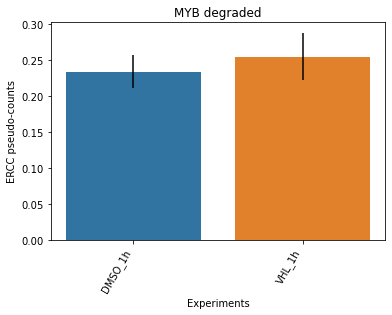

Saved to ../results/slamseq_MYB_degraded_v1/plots/MYB_degraded_v1_scaling_fact_with_conf.pdf


<Figure size 432x288 with 0 Axes>

In [143]:
version = project.replace("_", " ").split(" ")[-1]
print(version)

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None,)
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])
plt.show()

plt.savefig(res_dir+"/plots/"+project+"_scaling_fact_with_conf.pdf")
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

## Saving the data in our bucket

rename bucket (remove YKL)

In [62]:
! gsutil ls gs://amlproject/RNA/slamseq/

gs://amlproject/RNA/slamseq/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed
gs://amlproject/RNA/slamseq/ref_genome.fa
gs://amlproject/RNA/slamseq/ref_genome.fa-enc.2.ngm
gs://amlproject/RNA/slamseq/ref_genome.fa-ht-13-2.3.ngm
gs://amlproject/RNA/slamseq/ref_genome.fa.fai
gs://amlproject/RNA/slamseq/IRF2BP2_degraded_YKL_v1/
gs://amlproject/RNA/slamseq/IRF2BP2degraded_v1/
gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/
gs://amlproject/RNA/slamseq/MYCpaper/


In [63]:
! gsutil mv gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1 gs://amlproject/RNA/slamseq/$project

Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_unpaired_1.fq.gz...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz_trimming_report.txt [Content-Type=

Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_unpaired_2.fq.gz...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_val_2.fq.gz...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001.fastq.gz_trimming_report.txt...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001_unpaired_1.fq.gz [Content-Type=application/

Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001.fastq.gz_trimming_report.txt...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001_unpaired_2.fq.gz...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001_val_2.fq.gz...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/fastqs/mr369-MV411-MYB-dTAG-VHL_1h-r5_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/pl

Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount_mins.bedgraph...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount_plus.bedgraph...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount.log [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount.log...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount.tsv [Content-Type=text/tab-separated-values]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount.tsv...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/c

Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount.log...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount.tsv [Content-Type=text/tab-separated-values]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount.tsv...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount_mins.bedgraph...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount_plus.bedgraph...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/re

Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam.bai...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.log [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.log...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam.bai [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam.bai...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/filter

Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr359-MV411-MYB-dTAG-DMSO_1h-r1_snp.vcf...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr360-MV411-MYB-dTAG-DMSO_1h-r2_snp.log [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr360-MV411-MYB-dTAG-DMSO_1h-r2_snp.log...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr360-MV411-MYB-dTAG-DMSO_1h-r2_snp.vcf [Content-Type=text/vcard]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr360-MV411-MYB-dTAG-DMSO_1h-r2_snp.vcf...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr361-MV411-MYB-dTAG-DMSO_1h-r3_snp.log [Content-Type=application/octet-stream]...
Removing gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr361-MV411-MYB-dTAG-DMSO_1h-r3_snp.log...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_YKL_v1/res/snp/mr361-MV411-MYB-dTAG-DMSO_1h-r3_snp.vcf [Content-Type=text/vcard]...
Removing

In [66]:
! gsutil ls gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degrade

In [67]:
! gsutil ls gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr362-MV411-MYB-dTAG-DMSO_1h-r4_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr362-MV411-MYB-dTAG-DMSO_1h-r4_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr363-MV411-MYB-dTAG-DMSO_1h-r5_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr363-MV411-

In [524]:
! gsutil -m cp ../../data/$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/$project/res_v4/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/$project/res_v4/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/$project/res_v4/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/$project/res_v4/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
conf

Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr367-MV411-MYB-dTAG-VHL_1h-r3_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr367-MV411-MYB-dTAG-VHL_1h-r3_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr367-MV411-MYB-dTAG-VHL_1h-r3_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/fastqs/mr368-MV411-MYB-dTAG-VHL_1h-r4_R2_001.fastq.gz_trimming

Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/ERCC_mr365-

Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/filter/mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.log [Content-Type=application/octet-stream]...
- [60/60 files][ 41.8 GiB/ 41.8 GiB] 100% Done 131.5 MiB/s ETA 00:00:00         
Operation completed over 60 objects/41.8 GiB.                                    
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/snp/mr359-MV411-MYB-dTAG-DMSO_1h-r1_snp.log [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/snp/mr359-MV411-MYB-dTAG-DMSO_1h-r1_snp.vcf [Content

Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/MYB_degraded_YKL_v1/res_v4/count/mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount_mins.bedgraph [Co

In [286]:
bam_files = ! ls ../../data/MYB_degraded_YKL_v1/res_v4/filter/mr*.bam

for bam in bam_files:
    print(os.path.basename(bam).split(".")[0])

mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered
mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered
mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered
mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered
mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered
mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered
mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered
mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered
mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered
mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered
mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered
mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered


# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## Count analysis

In [3]:
project = "MYB_degraded_v1"
res_folder = "res_v4"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v4/count/


In [4]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

rewrote readFromSlamdunk

<li>readcounts: total counts of every transscript (output of slamdunk algorithm)
<li>tccounts: t to c converted RNA transcripts

In [24]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 12 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount', 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount', 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount', 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount', 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount', 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount', 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount', 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount', 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount', 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount', 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount', 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
mr360-MV411-MYB-dTAG-DMSO_1h-r2
mr361-MV411-MYB-dTAG-DMSO_1h-r3
mr362-MV411-MYB-dTAG-DMSO_1h-r4
mr363-MV411-MYB-dTAG-DMSO_1h-r5
mr364-MV411-MYB-dTAG-DMSO_1h-r6
mr365-MV411-MYB-dTAG-VHL_1h-r1
mr366-MV411-MYB-dTAG-VHL_1h-r2
mr367-MV411-MYB-dTAG-VHL_1h-r3
mr368-MV411-MYB-dTAG-VHL_1h-r4
mr369-MV411-MYB-dTAG-VHL_1h-r5
mr370-MV411-MYB-dTAG-VHL_1h-r6
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
d

In [18]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

Sum duplicate gene rows

In [19]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

Duplicate gene rows!
16588 rows | 16558 unique genes
Summing of duplicate gene rows.


### Sum duplicate gene rows

In [318]:
if readcounts.shape[0] != len(readcounts.index.drop_duplicates()):
    print("Duplicate gene rows!")
    print("{} rows | {} unique genes".format(readcounts.shape[0], len(readcounts.index.drop_duplicates())))
    print("Summing of duplicate gene rows.")
    
    # sum duplicate rows, same row order
    duplicate_genes = readcounts.index[readcounts.index.duplicated()].tolist()
    readcounts = readcounts.groupby(readcounts.index).sum().loc[readcounts.index.drop_duplicates()]
    if readcounts.shape[0] != len(readcounts.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )

Duplicate gene rows!
16588 unique genes | 16558 rows
Summing of duplicate gene rows.


In [319]:
if tccounts.shape[0] != len(tccounts.index.drop_duplicates()):
    print("Duplicate gene rows!")
    print("{} unique genes | {} rows".format(tccounts.shape[0], len(tccounts.index.drop_duplicates())))
    print("Summing of duplicate gene rows.")
    
    # sum duplicate rows, same row order
    duplicate_genes = readcounts.index[readcounts.index.duplicated()].tolist()
    tccounts = tccounts.groupby(tccounts.index).sum().loc[tccounts.index.drop_duplicates()]
    if tccounts.shape[0] != len(tccounts.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )

Duplicate gene rows!
16588 unique genes | 16558 rows
Summing of duplicate gene rows.


In [36]:
print("Readcounts rows: {}".format(readcounts.shape[0]))
print("Unique readcounts genes: {}".format(len(readcounts.index.drop_duplicates())))

if readcounts.shape[0] != len(readcounts.index.unique().tolist()):
    print("\nUnique genes NOT equal to number of rows!!!")
    print("Duplicate rows: {}".format(readcounts.shape[0] - len(readcounts.index.drop_duplicates(keep=False))))
    print("Duplicate genes: {}".format(readcounts.shape[0] - len(readcounts.index.unique().tolist())))

Readcounts rows: 16588
Unique readcounts genes: 16558

Unique genes NOT equal to number of rows!!!
Duplicate rows: 60
Duplicate genes: 30


In [37]:
print("Tccounts rows: {}".format(tccounts.shape[0]))
print("Unique tccounts genes: {}".format(len(tccounts.index.drop_duplicates())))

if readcounts.shape[0] != len(readcounts.index.unique().tolist()):
    print("\nUnique genes NOT equal to number of rows!!!")
    print("Duplicate rows: {}".format(tccounts.shape[0] - len(tccounts.index.drop_duplicates(keep=False))))
    print("Duplicate genes: {}".format(tccounts.shape[0] - len(tccounts.index.unique().tolist())))

Tccounts rows: 16588
Unique tccounts genes: 16558

Unique genes NOT equal to number of rows!!!
Duplicate rows: 60
Duplicate genes: 30


In [41]:
len(readcounts.index.drop_duplicates()) # total number of unique genes (without duplicates)

16558

In [17]:
duplicate_genes = readcounts.index[readcounts.index.duplicated()].tolist()

30


In [20]:
df_dup = readcounts.loc[duplicate_genes]
print(df_dup.shape)

(60, 12)


In [28]:
df_dup.head()

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
CHML,1949,1909,1898,2257,1308,1600,2197,3341,2265,2141,1395,2531
CHML,1247,1305,1230,1357,835,949,1385,1784,1327,1383,1196,1515
SMIM8,124,111,108,144,57,88,121,148,93,119,79,128
SMIM8,8,6,9,4,7,3,5,8,6,5,2,11
USP9Y,0,4,0,3,1,0,5,4,1,2,2,4


In [27]:
df_dup.groupby(df_dup.index).sum().loc[duplicate_genes]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
CHML,3196,3214,3128,3614,2143,2549,3582,5125,3592,3524,2591,4046
SMIM8,132,117,117,148,64,91,126,156,99,124,81,139
USP9Y,2,10,5,5,3,3,8,8,5,4,3,9
MICAL2,433,376,409,471,225,254,317,435,361,348,281,407
S1PR3,254,242,296,380,186,229,200,296,226,214,165,204
MCL1,7504,7374,7538,8493,4823,4992,6560,8863,6568,6952,5203,7579
LINC00598,9,13,10,14,10,11,18,9,12,19,3,14
CCDC26,607,636,582,699,401,383,455,645,473,496,509,547
MTPN,7493,7684,7599,8536,4916,5344,6855,9297,7166,7695,6173,7667
SCARNA9,633,631,588,752,300,343,531,651,513,550,348,697


In [47]:
# sum duplicate rows, same row order
readcounts = readcounts.groupby(readcounts.index).sum().loc[readcounts.index.drop_duplicates()]
tccounts = tccounts.groupby(tccounts.index).sum().loc[tccounts.index.drop_duplicates()]

In [40]:
print(readcounts.shape)
print(tccounts.shape)

(16588, 12)
(16588, 12)


## Testing changing taiga dependency

<ul>
    <li>taigepy & tc to generateGeneNames
    <li>filterProteinCoding
    <li>convertGenes
    <li>readFromSlamdunk

In [1175]:
count_files = ! ls $location
count_files = [file for file in count_files if file.endswith(".tsv")]

sample_names = [file.split("_tcount.tsv")[0] for file in count_files]
sample_names

['mr359-MV411-MYB-dTAG-DMSO_1h-r1',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6']

In [1176]:
test_samples = sample_names[0:3]
files = [location+file for file in count_files[0:3]]
print(test_samples)
print(files)

['mr359-MV411-MYB-dTAG-DMSO_1h-r1', 'mr360-MV411-MYB-dTAG-DMSO_1h-r2', 'mr361-MV411-MYB-dTAG-DMSO_1h-r3']
['../../data/MYB_degraded_v1/res_v4/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv', '../../data/MYB_degraded_v1/res_v4/count/mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount.tsv', '../../data/MYB_degraded_v1/res_v4/count/mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount.tsv']


In [1177]:
names_list = []
unique_names_list = []
for file in files:
    print(os.path.basename(file).split("_tcount")[0])
    df = pd.read_csv(file, sep='\t', comment='#', header=0)
    print(df.shape)
    names_list.append(df["Name"].tolist())
    unique_names_list.append(df["Name"].unique())

mr359-MV411-MYB-dTAG-DMSO_1h-r1
(58136, 16)
mr360-MV411-MYB-dTAG-DMSO_1h-r2
(58136, 16)
mr361-MV411-MYB-dTAG-DMSO_1h-r3
(58136, 16)


In [34]:
readcounts_dedup

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
A1BG,2,1,1,1,5,0,0,5,0,0,5,2
A2MP1,6,7,8,11,1,4,1,10,5,8,3,6
NAT1,56,53,57,73,54,50,70,83,65,59,38,75
AADAC,4,1,3,8,0,3,2,5,2,1,0,2
AAMP,419,372,432,507,218,246,373,384,344,383,271,425
...,...,...,...,...,...,...,...,...,...,...,...,...
TBC1D7,294,300,311,344,177,159,261,264,239,279,261,291
GNMT,8,22,18,14,8,6,18,24,6,16,6,20
BOLA2-SMG1P6,4,0,4,5,3,3,2,6,1,5,3,3
107303344,187,171,184,209,113,76,183,191,147,186,132,203


In [1178]:
print(names_list[0] == names_list[1] == names_list[2])
print(np.array_equal(unique_names_list[0],unique_names_list[1]))# == unique_names_list[2])
print(np.array_equal(unique_names_list[1],unique_names_list[2]))
print(len(unique_names_list[0]))

True
True
True
25420


In [1113]:
data = {}
for file in files:
    data[file.split('/')[-1].split('.')[0]] = pd.read_csv(file, sep='\t', comment='#', header=0)
prev = -2
print("found " + str(len(data)) + ' files:' + str(data.keys()))

found 3 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount', 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount', 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount'])


In [1121]:
print(sample_names[0])
print(data[sample_names[0]+"_tcount"].shape)
print("Unique names: {}".format(len(data[sample_names[0]+"_tcount"].Name.unique())))
data[sample_names[0]+"_tcount"].iloc[:5,]

mr359-MV411-MYB-dTAG-DMSO_1h-r1
(58136, 16)
Unique names: 25420


,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.098796,112,78,0,6,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.008555,1.926521,242,3156,27,117,9,0,-1.0,-1.0
2,chr12,109448654,109451813,83892,3159,-,0.003213,16.219005,921,36417,117,985,38,0,-1.0,-1.0
3,chr12,109456117,109456313,83892,196,-,0.003135,0.872698,57,1595,5,53,2,0,-1.0,-1.0
4,chr12,109457629,109457682,83892,53,-,0.000000,0.082330,10,50,0,5,0,0,-1.0,-1.0


In [1123]:
for k, val in data.items():
    if len(set(val.Name)) != prev and prev != -2:
        raise ValueError(
            'we do not have the same number of genes in each file')
    prev = len(set(val.Name))

# make dict for each unique gene: list of 0s per sample (can be multiple regions)
readcounts = {i: [0] * len(data) for i in val.Name.unique()}
tccounts = {i: [0] * len(data) for i in val.Name.unique()}

In [1125]:
print(val.shape)
len(val.Name.unique())

(58136, 16)


25420

In [1126]:
len(readcounts)

25420

In [1044]:
#for n, (_, val) in enumerate(data.items()):
#    print(n)
#    print(_)
#    print(val.sort_values(by="Name"))

In [1127]:
for n, (_, val) in enumerate(data.items()):
    print(_.split("_tcount")[0])
    val = val.sort_values(by="Name")        # make df rows ordered by gene name
    j = 0
    readcount = [val.iloc[0].ReadCount]     # get ReadCount at first row
    tccount = [val.iloc[0].TcReadCount]     # get TcTeadCount at first row
    prevname = val.iloc[0].Name             # get row Name
    # repeat for all rows
    for _, v in val.iloc[1:].iterrows():
        if v.Name == 4609:                  # not sure why this specific region?
            print(v.ReadCount, v.TcReadCount)
            print(readcount, tccount)
        if v.Name == prevname:              # add counts to rows with the same name
            readcount.append(v.ReadCount)
            tccount.append(v.TcReadCount)
        else:
            readcounts[prevname][n] = np.sum(readcount) # sum read counts in rows with the same name
            tccounts[prevname][n] = np.sum(tccount)
            # if np.var(readcount) > flag_var:
            #    print("pb with "+str(v.Name))
            prevname = v.Name               # new gene name for region
            j += 1
            # print(j,end='\r')
            readcount = [v.ReadCount]       # get read count for new region
            tccount = [v.TcReadCount]

mr359-MV411-MYB-dTAG-DMSO_1h-r1
703 282
[128, 10] [7, 4]
mr360-MV411-MYB-dTAG-DMSO_1h-r2
673 262
[94, 7] [5, 3]
mr361-MV411-MYB-dTAG-DMSO_1h-r3
903 397
[134, 10] [4, 3]


In [1129]:
data[list(data.keys())[0]].iloc[:2]

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.098796,112,78,0,6,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.008555,1.926521,242,3156,27,117,9,0,-1.0,-1.0


In [1130]:
files = [*data]
readcounts = pd.DataFrame(
    data=readcounts, columns=val.Name.unique(), index=data.keys()).T
tccounts = pd.DataFrame(
    data=tccounts, columns=val.Name.unique(), index=data.keys()).T

In [1131]:
readcounts.iloc[:2]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount
1,2,1,1
2,2,2,2


In [1132]:
readcounts.shape

(25420, 3)

In [1133]:
tccounts.iloc[:2]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount
1,0,0,0
2,0,0,0


In [1134]:
print(readcounts.index.tolist()[:5])
print(tccounts.index.tolist()[:5])
print(readcounts.index.tolist() == tccounts.index.tolist())

[1, 2, 3, 9, 10]
[1, 2, 3, 9, 10]
True


Convert gene name formats
<li>from_idtype = entrez_id
<li>to_idtype = symbol

In [828]:
%%time

# cache_folder = FALSE
readcounts, tccounts = readFromSlamdunk(loc=location, 
                                        minvar_toremove=minvar_toremove, 
                                        mincount_toremove=mincount_toremove,
                                        verbose=False)

found 12 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount', 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount', 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount', 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount', 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount', 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount', 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount', 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount', 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount', 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount', 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount', 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
mr360-MV411-MYB-dTAG-DMSO_1h-r2
mr361-MV411-MYB-dTAG-DMSO_1h-r3
mr362-MV411-MYB-dTAG-DMSO_1h-r4
mr363-MV411-MYB-dTAG-DMSO_1h-r5
mr364-MV411-MYB-dTAG-DMSO_1h-r6
mr365-MV411-MYB-dTAG-VHL_1h-r1
mr366-MV411-MYB-dTAG-VHL_1h-r2
mr367-MV411-MYB-dTAG-VHL_1h-r3
mr368-MV411-MYB-dTAG-VHL_1h-r4
mr369-MV411-MYB-dTAG-VHL_1h-r5
mr370-MV411-MYB-dTAG-VHL_1h-r6
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
d

In [1065]:
def readFromSlamdunk(loc="res/count/", flag_var=100, convertTo="hgnc_symbol",
                     minvar_toremove=0, mincount_toremove=5, verbose=True):
    
    """
    Given a list of genes, provide the args where the genes are protein coding genes (or given biotype):
    
    Args:
    -----
      listofgenes: list of genes
      from_idtype: one of "ensemble_gene_id","clone_based_ensembl_gene","hgnc_symbol","gene_biotype","entrezgene_id", the gene name format
      to_idtype: one of "ensemble_gene_id","clone_based_ensembl_gene","hgnc_symbol","gene_biotype","entrezgene_id", the gene name format
      gene_biotype: gene/transcript biotype
      verbose: print total counts and t to c converted counts at MYC
    
    Returns:
    -------
      1: the new names for each genes that were matched else the same name
      2: the names of genes that could not be matched
    """
    
    files = sorted(os.listdir(loc)) # sorted files
    files = [file for file in files if file.endswith(".tsv")]
    data = {}
    for file in files:
        data[file.split('/')[-1].split('.')[0]] = pd.read_csv(loc+file, sep='\t', comment='#', header=0)
    
    prev = -2
    print("found " + str(len(data)) + ' files:' + str(data.keys()))
    
    for k, val in data.items():
        if len(set(val.Name)) != prev and prev != -2:
            raise ValueError(
                'we do not have the same number of genes in each file')
        prev = len(set(val.Name))

    # make dict for each unique gene of list of 0s per sample (can be multiple regions)
    readcounts = {i: [0] * len(data) for i in val.Name.unique()}
    tccounts = {i: [0] * len(data) for i in val.Name.unique()}
    
    for n, (_, val) in enumerate(data.items()):
        print(_.split("_tcount")[0])
        val = val.sort_values(by="Name")        # make df rows ordered by gene name
        j = 0
        readcount = [val.iloc[0].ReadCount]     # get ReadCount at first row
        tccount = [val.iloc[0].TcReadCount]     # get TcReadCount at first row
        prevname = val.iloc[0].Name             # get row Name
        
        # repeat for all rows
        for _, v in val.iloc[1:].iterrows():
            if v.Name == 4609 and verbose:                  # MYC region (for QC purposes)
                print("MYC Total counts: {}".format(v.ReadCount))
                print("MYC T to C converted counts: {}".format(v.TcReadCount))
                #print(readcount, tccount)
            if v.Name == prevname:              # add counts to rows with the same name
                readcount.append(v.ReadCount)
                tccount.append(v.TcReadCount)
            else:
                readcounts[prevname][n] = np.sum(readcount) # sum read counts in rows with the same name
                tccounts[prevname][n] = np.sum(tccount)
                # if np.var(readcount) > flag_var:
                #    print("pb with "+str(v.Name))
                prevname = v.Name               # new gene name for region
                j += 1
                # print(j,end='\r')
                readcount = [v.ReadCount]       # get read count for new region
                tccount = [v.TcReadCount]
    
    files = [*data]
    readcounts = pd.DataFrame(
        data=readcounts, columns=val.Name.unique(), index=data.keys()).T
    tccounts = pd.DataFrame(
        data=tccounts, columns=val.Name.unique(), index=data.keys()).T
    
    # convert to gene symbols
    if convertTo:
        names, _ = convertGenes(readcounts.index.tolist(), 
                                from_idtype = "entrezgene_id", to_idtype = "hgnc_symbol")
        readcounts.index = names
        
        names, _ = convertGenes(tccounts.index.tolist(), 
                                from_idtype = "entrezgene_id", to_idtype = "hgnc_symbol")
        tccounts.index = names
    
    nottodrop = np.argwhere(tccounts.values.var(1) >= # remove regions/genes with variance of 0 across samples
                            minvar_toremove).ravel()
    tccounts = tccounts.iloc[nottodrop]
    readcounts = readcounts.iloc[nottodrop]
    nottodrop = np.argwhere(readcounts.values.max(1) >= # remove regions/genes with very low counts
                            mincount_toremove).ravel() 
    tccounts = tccounts.iloc[nottodrop]
    readcounts = readcounts.iloc[nottodrop]
    return readcounts, tccounts

In [1136]:
def convertGenes(listofgenes, from_idtype="ensemble_gene_id", to_idtype="hgnc_symbol"):
    """
    Given a list of genes, will convert to different ID type
    
    Args:
    -----
      listofgenes: list of genes
      from_idtype: one of "ensemble_gene_id","clone_based_ensembl_gene","hgnc_symbol","gene_biotype","entrezgene_id", the gene name format
      to_idtype: one of "ensemble_gene_id","clone_based_ensembl_gene","hgnc_symbol","gene_biotype","entrezgene_id", the gene name format
    
    Returns:
    -------
      1: the new names for each genes that were matched else the same name
      2: the names of genes that could not be matched
    """
    
    gene_mapping = h.generateGeneNames()
    
    not_parsed = []
    renamed = []
    b = 0
    to = {}
    
    for i, val in gene_mapping.iterrows():
        to[val[from_idtype]] = val[to_idtype]
        
    for i, val in enumerate(listofgenes):
        if from_idtype == "ensembl_gene_id":
            val = val.split(".")[0]
        elif from_idtype == "entrezgene_id":
            try:
                a = to[val]
                renamed.append(a)
            except KeyError:
                b += 1
                not_parsed.append(val)
                renamed.append(val)
    print(str(b) + " count not be parsed... we don't have all genes already")
    return(renamed, not_parsed)

In [1137]:
names, _ = convertGenes(readcounts.index.tolist(), from_idtype = "entrezgene_id", to_idtype = "hgnc_symbol")

downloading gene names from biomart
1750 count not be parsed... we don't have all genes already


In [1138]:
print(len(names))
print(len(_))

25420
1750


In [1140]:
gene_mapping = h.generateGeneNames()

downloading gene names from biomart


In [1148]:
gene_mapping.iloc[:5,:]

,ensembl_gene_id,clone_based_ensembl_gene,hgnc_symbol,gene_biotype,entrezgene_id
0,ENSG00000210049,NaN,MT-TF,Mt_tRNA,NaN
1,ENSG00000211459,NaN,MT-RNR1,Mt_rRNA,NaN
2,ENSG00000210077,NaN,MT-TV,Mt_tRNA,NaN
3,ENSG00000210082,NaN,MT-RNR2,Mt_rRNA,NaN
4,ENSG00000209082,NaN,MT-TL1,Mt_tRNA,NaN


In [811]:
gene_mapping.loc[gene_mapping["entrezgene_id"] == 4609]

,ensembl_gene_id,clone_based_ensembl_gene,hgnc_symbol,gene_biotype,entrezgene_id
33810,ENSG00000136997,NaN,MYC,protein_coding,4609.0


In [760]:
gene_mapping.loc[gene_mapping["hgnc_symbol"] %in% 'A1BG']

,ensembl_gene_id,clone_based_ensembl_gene,hgnc_symbol,gene_biotype,entrezgene_id
55190,ENSG00000121410,NaN,A1BG,protein_coding,1.0


In [731]:
print(len(gene_mapping[gene_mapping["entrezgene_id"].notnull()]["entrezgene_id"]))
print(min(gene_mapping[gene_mapping["entrezgene_id"].notnull()]["entrezgene_id"]))
print(max(gene_mapping[gene_mapping["entrezgene_id"].notnull()]["entrezgene_id"]))

28404
1.0
116804918.0


In [709]:
from_idtype = "entrezgene_id"
to_idtype = "hgnc_symbol"

In [697]:
gene_mapping = h.generateGeneNames()

downloading gene names from biomart


In [779]:
gene_mapping.loc[gene_mapping["gene_biotype"] == "protein_coding"]

,ensembl_gene_id,clone_based_ensembl_gene,hgnc_symbol,gene_biotype,entrezgene_id
5,ENSG00000198888,NaN,MT-ND1,protein_coding,4535.0
9,ENSG00000198763,NaN,MT-ND2,protein_coding,4536.0
15,ENSG00000198804,NaN,MT-CO1,protein_coding,4512.0
18,ENSG00000198712,NaN,MT-CO2,protein_coding,4513.0
20,ENSG00000228253,NaN,MT-ATP8,protein_coding,4509.0
...,...,...,...,...,...
67399,ENSG00000167363,NaN,FN3K,protein_coding,64122.0
67401,ENSG00000141556,NaN,TBCD,protein_coding,6904.0
67403,ENSG00000141579,NaN,ZNF750,protein_coding,79755.0
67405,ENSG00000175711,NaN,B3GNTL1,protein_coding,146712.0


In [732]:
listofgenes = readcounts.index.tolist()

In [739]:
listofgenes[:5]

[1, 2, 3, 9, 10]

In [784]:
not_parsed = []
renamed = []
b = 0
to = {}

# protein coding genes to dict
for i, val in gene_mapping.loc[gene_mapping["gene_biotype"] == "protein_coding"].iterrows():
    to[val[from_idtype]] = val[to_idtype]

In [785]:
for i, val in enumerate(listofgenes):
    if from_idtype == "ensembl_gene_id":
        val = val.split(".")[0]
    elif from_idtype == "entrezgene_id":
        try:
            a = to[val]
            renamed.append(a)
        except KeyError:
            b += 1
            not_parsed.append(val)
            renamed.append(val)
print(str(b) + " count not be parsed... we don't have all genes already")

6682 count not be parsed... we don't have all genes already


In [758]:
print(len(renamed))
print(len(not_parsed))
renamed[:5]

25420
1750


['A1BG', 'A2M', 'A2MP1', 'NAT1', 'NAT2']

## Make count files

### Make density plot

In [79]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
! mkdir $res_dir

../results/slamseq_MYB_degraded_v1/


In [59]:
col = tccounts.columns.tolist() # sort cols
col.sort()
tccounts = tccounts[col]

In [60]:
col = readcounts.columns.tolist() # sort cols
col.sort()
readcounts = readcounts[col]

In [61]:
print(readcounts.shape)
readcounts.iloc[:2]

(16558, 12)


,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
A1BG,2,1,1,1,5,0,0,5,0,0,5,2
A2MP1,6,7,8,11,1,4,1,10,5,8,3,6


15535


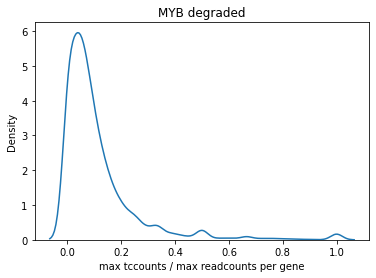

In [72]:
# what is the average of highly transcribed genes
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])
plt.show()

In [63]:
# median of T -> C converted
np.median(a)

0.06944444444444445

In [73]:
readcounts.iloc[:1]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
A1BG,2,1,1,1,5,0,0,5,0,0,5,2


In [81]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv", index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_0_5_tccounts.csv


### Make more dfs (mean, median, etc.)

In [82]:
readcounts.iloc[:1]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
A1BG,2,1,1,1,5,0,0,5,0,0,5,2


In [83]:
readcounts.columns.tolist()

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount']

In [84]:
print(set([i.split('-')[-2] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])

{'VHL_1h', 'DMSO_1h'}
['mr359', 'MV411-MYB-dTAG-DMSO_1h-r1_tcount']
MV411-MYB-dTAG-DMSO_1h


{'MV411-MYB-dTAG-DMSO_1h', 'MV411-MYB-dTAG-VHL_1h'}

In [85]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
print(set([i.split('-')[-2] for i in tccounts.columns]))
for i in set([i.split('-')[-2] for i in tccounts.columns]):
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

{'VHL_1h', 'DMSO_1h'}


In [86]:
# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

In [87]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
print(set([i.split('-')[-2] for i in tccounts.columns]))
for i in set([i.split('-')[-2] for i in tccounts.columns]):
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

{'VHL_1h', 'DMSO_1h'}


In [88]:
# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

In [89]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
A1BG,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2MP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_0_5_tccounts_per_readcounts.csv


## Looking at similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [91]:
tccounts.columns.tolist()

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount']

In [58]:
#tccounts.columns = [i.replace('-','.') for i in tccounts.columns]
#readcounts.columns = [i.replace('-','.') for i in readcounts.columns]

['mr359.MV411.MYB.dTAG.DMSO_1h.r1_tcount',
 'mr360.MV411.MYB.dTAG.DMSO_1h.r2_tcount',
 'mr361.MV411.MYB.dTAG.DMSO_1h.r3_tcount',
 'mr362.MV411.MYB.dTAG.DMSO_1h.r4_tcount',
 'mr363.MV411.MYB.dTAG.DMSO_1h.r5_tcount',
 'mr364.MV411.MYB.dTAG.DMSO_1h.r6_tcount',
 'mr365.MV411.MYB.dTAG.VHL_1h.r1_tcount',
 'mr366.MV411.MYB.dTAG.VHL_1h.r2_tcount',
 'mr367.MV411.MYB.dTAG.VHL_1h.r3_tcount',
 'mr368.MV411.MYB.dTAG.VHL_1h.r4_tcount',
 'mr369.MV411.MYB.dTAG.VHL_1h.r5_tcount',
 'mr370.MV411.MYB.dTAG.VHL_1h.r6_tcount']

In [92]:
mkdir ../results/slamseq_$project/plots/

In [95]:
# tccounts MYC/total avg / readcounts MYC/total avg
(tccounts.loc["MYC"]/tccounts.mean(0))/(readcounts.loc["MYC"]/readcounts.mean(0))

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    12.760993
mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount    14.295433
mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount    11.272511
mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount    11.117835
mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount    12.751926
mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount     8.718355
mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount      9.512563
mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount      9.144115
mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount     11.930208
mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount      8.666230
mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount     21.181848
mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount     10.106626
dtype: float64

In [96]:
[i.rpartition("_")[0] for i in tccounts.columns.tolist()] # name w/o _tccounts
[i.split('-')[-2] for i in tccounts.columns] # just condition (no replicate)
#print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns] # condition w/ replicate

['DMSO_1h-r1',
 'DMSO_1h-r2',
 'DMSO_1h-r3',
 'DMSO_1h-r4',
 'DMSO_1h-r5',
 'DMSO_1h-r6',
 'VHL_1h-r1',
 'VHL_1h-r2',
 'VHL_1h-r3',
 'VHL_1h-r4',
 'VHL_1h-r5',
 'VHL_1h-r6']

#### Plot formatting
- set font
- custom color palettes

In [97]:
from matplotlib.colors import LinearSegmentedColormap

palettelist = ["seismic"]
cmp_cylin = LinearSegmentedColormap.from_list("", ["#ffffff", "#e60000"]) #white to red
#sns.color_palette("light:#e60000", as_cmap=True) # similar
cmp_brewer = LinearSegmentedColormap.from_list("", ["#0000FF", "#FFFFFF", "#FF0000"]) #blue, white, red
cmp_usa = LinearSegmentedColormap.from_list("", ["#0000FF", "#FFFFFF", "#FF0000"][::-1]) #red, white, blue

In [98]:
import matplotlib as mpl
import matplotlib.font_manager

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['font.sans-serif'] = ["Arial"]
#mpl.rc('font', family='sans-serif',size=8)

# change the default font family
#plt.rcParams.update({'font.family':'Arial'})
# reset the plot configurations to default
#plt.rcdefaults()

#### Save plots to pdf function

In [300]:
from matplotlib.backends.backend_pdf import PdfPages

def write_pdf(fname, figures):
    ''' save multiple plots to pdf '''
    doc = PdfPages(fname)
    for fig in figures:
        fig.savefig(doc, format='pdf')
    doc.close()

In [301]:
# open pdf file
replicates_file = '../results/'+project+'/plots/'+project+'_similarity_replicates_sorted.pdf'
print(replicates_file)
#pp = PdfPages(replicates_file)
figures = []

../results/MYB_degraded_YKL_v1/plots/MYB_degraded_YKL_v1_similarity_replicates_sorted.pdf


In [302]:
# save with condition name
# tccounts
fig_tccounts, ax = plt.subplots(figsize=(8,8))
sns.heatmap(tccounts.corr(), 
            xticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns], # condition w/ replicate
            yticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, 
            #vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()
plt.close()
figures.append(fig_tccounts)

# readcounts
fig_readcounts, ax = plt.subplots(figsize=(8,8))
sns.heatmap(readcounts.corr(), 
            xticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in readcounts.columns], # condition w/ replicate
            yticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in readcounts.columns],
            ax=ax)#, cmap=cmp_cylin)
            #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()
plt.close()
figures.append(fig_readcounts)

In [303]:
# save with full sample name
# tccounts
fig_tccounts_named, ax = plt.subplots(figsize=(8,8))
sns.heatmap(tccounts.corr(), 
            xticklabels=[i.rpartition("_")[0] for i in tccounts.columns], # name w/o _tccounts
            yticklabels=[i.rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, 
            #vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()
plt.close()
figures.append(fig_tccounts_named)

# readcounts
fig_readcounts_named, ax = plt.subplots(figsize=(8,8))
sns.heatmap(readcounts.corr(), 
            xticklabels=[i.rpartition("_")[0] for i in readcounts.columns], # condition w/ replicate
            yticklabels=[i.rpartition("_")[0] for i in readcounts.columns],
            ax=ax)#, cmap=cmp_cylin)
            #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()
plt.close()
figures.append(fig_readcounts_named)

In [304]:
write_pdf(replicates_file, figures)

#### Save plots to pdf

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_v1/plots/MYB_degraded_v1_similarity_replicates_sorted_tccounts.pdf


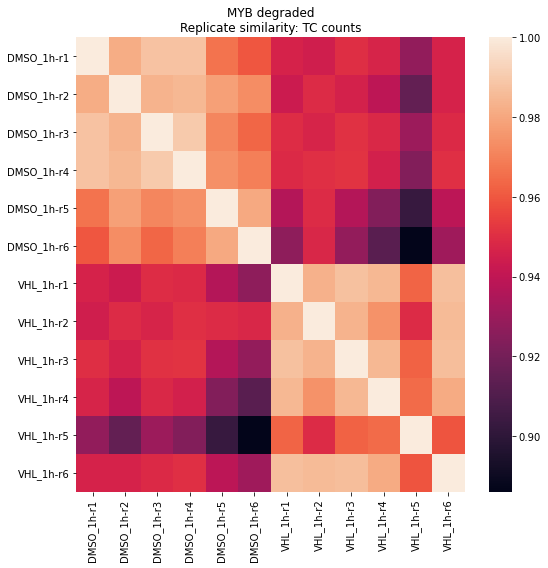

In [103]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    #"sans-serif" : "Arial",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(tccounts.corr(), 
            xticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns], # condition w/ replicate
            yticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, 
            #vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_v1/plots/MYB_degraded_v1_similarity_replicates_sorted_readcounts.pdf


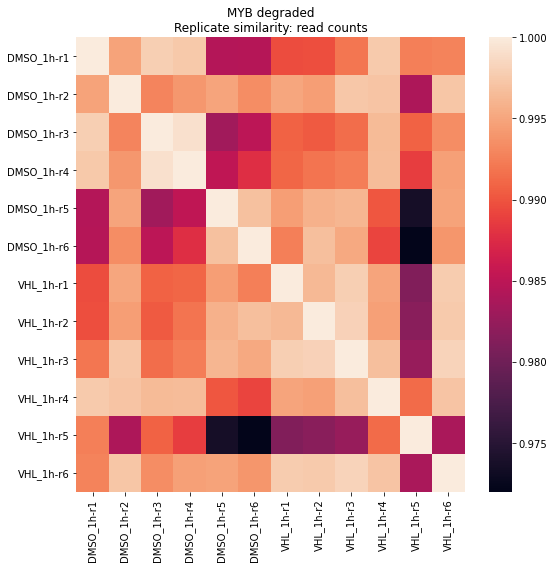

In [104]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(readcounts.corr(), 
            xticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns], # condition w/ replicate
            yticklabels=[i.rpartition("_")[0].split("-",4)[-1] for i in tccounts.columns],
            ax=ax)#, cmap=cmp_cylin)
            #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

In [309]:
readcounts.shape

(16588, 12)

### A quick detour to look for clustering

## Getting the Core TF information

In [784]:
ctf=pd.read_csv('../data/CTF.csv',header=None)[0].values.tolist()
ctf

['ARID2',
 'CEBPA',
 'CEBPE',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'GFI1B',
 'HHEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MTF1',
 'MYB',
 'MYC',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SETDB1',
 'SNAPC5',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TERF2',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZMYND8',
 'LMO2',
 'MAX',
 'ELF2',
 'ETV6',
 'HOXA9',
 'GATA2']

In [785]:
set(ctf) & set(tccounts.index)

{'ARID2',
 'CEBPA',
 'CEBPE',
 'E2F3',
 'ELF2',
 'ETV6',
 'FLI1',
 'FOSL2',
 'GATA2',
 'GFI1',
 'GFI1B',
 'HHEX',
 'HOXA9',
 'IRF8',
 'LMO2',
 'LYL1',
 'MAX',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MTF1',
 'MYB',
 'MYC',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SETDB1',
 'SNAPC5',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TERF2',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZMYND8'}

In [786]:
ctfpos = [val for val in tccounts.index if val in ctf]
notctfpos = [val for val in tccounts.index if val not in ctf]

In [787]:
ctfpos.extend(['EGR1','SERTAD1'])

We find a CTF not in the dataset

## Let's look at how they change accross time

how core transcription factors change accross time when the cell is with JQ1 conditions

we are looking at the difference between production of each CTF compared to the average RNA production with JQ1 and without JQ1

## DESEQ ANALYSIS

Original code

In [148]:
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [150]:
tccounts.columns[:-1].tolist()

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount']

In [168]:
# MYB degraded YKL
# tccounts
tccountsMYB = tccounts[tccounts.columns[:-1]]
print(tccountsMYB.shape)
designMYB = pd.DataFrame(index= [i.replace('-','.') for i in tccountsMYB.columns], 
                         columns=['DMSO','VHL'], 
                         data=np.array([[1,1,1,1,1,1,0,0,0,0,0,0],
                                        [0,0,0,0,0,0,1,1,1,1,1,1]],dtype=bool).T)
designMYB

(16558, 12)


,DMSO,VHL
mr359.MV411.MYB.dTAG.DMSO_1h.r1_tcount,True,False
mr360.MV411.MYB.dTAG.DMSO_1h.r2_tcount,True,False
mr361.MV411.MYB.dTAG.DMSO_1h.r3_tcount,True,False
mr362.MV411.MYB.dTAG.DMSO_1h.r4_tcount,True,False
mr363.MV411.MYB.dTAG.DMSO_1h.r5_tcount,True,False
mr364.MV411.MYB.dTAG.DMSO_1h.r6_tcount,True,False
mr365.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,True
mr366.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,True
mr367.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,True
mr368.MV411.MYB.dTAG.VHL_1h.r4_tcount,False,True


### Differential gene expression analysis, PCA and GO-term enrichment

For gene-level analysis, raw reads mapped to different UTR annotations of the same gene were summed up by Entrez Gene ID. Pilot studies of K562 cells with kinase inhibitors were performed as single experiments. 

Analysis of differential gene expression was restricted to genes with ≥ 10 reads in at least one condition for 50bp sequencing runs (flavopiridol and DMSO) or ≥ 20 reads in at least one condition for 100bp sequencing runs (mk2206, trametinib, nilotinib, trametinib + mk2206 and DMSO). For estimating differential expression, a pseudo-count of 1 raw read was added to all genes.

__All other SLAM-seq experiments were performed in triplicates and analyzed as follows.__
Differential gene expression calling was performed on raw read counts with ≥ 2 T>C conversions using DESeq2 (version 1.14.1) with default settings, and with size factors estimated on corresponding total mRNA reads for global normalization.

Downstream analysis was restricted to genes passing all internal filters for FDR estimation by DESeq2. Principal component analysis was performed after variance
stabilizing transformation on the 500 most variable genes across all conditions of a given
experiment. GO-term enrichment analysis was performed on genes significantly and strongly downregulated (FDR ≤ 0.1, log2FC ≤ -1) in SLAM-seq upon IAA-treatment in K562MYC-AID + Tir1 by the PANTHER Overrepresentation Test (Fisher's Exact with FDR multiple test correction, release 20171205, http://pantherdb.org) on GO Ontology database Released 2017-12-27.

### Making DESeq obj

In [170]:
# readcounts
readcountsMYB = readcounts[['genes']+list(readcountsMYB.columns)[:-1]]
# tccounts
tccountsMYB = tccounts[['genes']+list(tccountsMYB.columns)] # same as original tccounts

MYB_1h = [1] * int(len(list(tccountsMYB.columns))-1) # change if multiple time points
MYB_1h

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [182]:
readcountsMYB = readcounts[['genes']+list(readcountsMYB.columns)[:-1]]

In [183]:
readcountsMYB.head()

,genes,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
0,A1BG,2,1,1,1,5,0,0,5,0,0,5,2
1,A2MP1,6,7,8,11,1,4,1,10,5,8,3,6
2,NAT1,56,53,57,73,54,50,70,83,65,59,38,75
3,AADAC,4,1,3,8,0,3,2,5,2,1,0,2
4,AAMP,419,372,432,507,218,246,373,384,344,383,271,425


In [175]:
tccountsMYB[tccountsMYB.columns[np.array([1]+MYB_1h, bool)]]

,genes,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount
0,A1BG,0,0,0,1,0,0,0,0,0,0,0,0
1,A2MP1,0,0,0,0,0,0,0,0,0,0,0,0
2,NAT1,5,8,3,2,1,3,3,8,5,2,6,12
3,AADAC,0,0,0,0,0,0,0,0,0,0,0,0
4,AAMP,7,6,13,17,2,11,14,18,9,12,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16553,106736475,5,4,7,6,7,6,4,15,3,11,3,8
16554,GET1-SH3BGR,0,0,1,0,0,1,0,0,0,0,0,0
16555,BOLA2-SMG1P6,0,0,0,0,0,1,0,0,0,0,0,1
16556,107303344,3,2,4,5,4,3,4,4,4,5,2,5


Should gene column be first now?
Before it was last

In [176]:
# tccounts
deseqMYB_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsMYB[tccountsMYB.columns[np.array([1]+MYB_1h, bool)]], 
                                design_matrix=designMYB[np.array(MYB_1h, bool)],
                                design_formula="~DMSO - VHL",
                                gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [184]:
# readcounts
deseqMYB_read = pyDESeq2.pyDESeq2(count_matrix=readcountsMYB[readcountsMYB.columns[np.array([1]+MYB_1h, bool)]], 
                                design_matrix=designMYB[np.array(MYB_1h, bool)],
                                design_formula="~DMSO - VHL",
                                gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


### estimating size factors

In [185]:
scaling="ERCCsamplewise"

In [186]:
readcounts.iloc[:1]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount,genes
0,2,1,1,1,5,0,0,5,0,0,5,2,A1BG


In [187]:
tccounts.iloc[:1]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount,genes
0,0,0,0,1,0,0,0,0,0,0,0,0,A1BG


In [188]:
readcounts.columns.tolist()

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount',
 'genes']

In [195]:
readcounts[tccountsMYB.columns[np.array([0]+MYB_DMSO, bool)]].values.shape

(16558, 6)

In [194]:
MYB_DMSO = [1,1,1,1,1,1,0,0,0,0,0,0]
readcounts[tccountsMYB.columns[np.array([0]+MYB_DMSO, bool)]].head()

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount
0,2,1,1,1,5,0
1,6,7,8,11,1,4
2,56,53,57,73,54,50
3,4,1,3,8,0,3
4,419,372,432,507,218,246


In [196]:
np.exp(np.mean(np.log(readcounts[tccountsMYB.columns[np.array([0]+MYB_DMSO, bool)]].values+1), 1))

array([  2.28942849,   6.26520516,  57.74001146, ...,   3.65905165,
       149.19198169,   4.03565431])

In [197]:
# tccounts
deseqMYB_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsMYB.columns[np.array([0]+MYB_DMSO, bool)]].values+1), 1)))

In [198]:
sizeFact_tc = deseqMYB_tc.getSizeFactors()
sizeFact_tc

array([0.94510477, 0.80113081, 1.1733139 , 1.42864716, 0.66429679,
       1.13996328, 1.27737768, 1.70044191, 1.0368592 , 1.05222991,
       0.38841296, 1.13036614])

In [199]:
# readcounts
deseqMYB_read.run_estimate_size_factors()

In [200]:
sizeFact_read = deseqMYB_read.getSizeFactors()
sizeFact_read

array([1.11458442, 1.07685607, 1.175023  , 1.32899755, 0.65868895,
       0.74127881, 0.9974183 , 1.27544769, 0.99325331, 1.07419471,
       0.76750414, 1.12338798])

### other size factor estimations (skip for now)

In [135]:
# from https://www.cell.com/trends/genetics/pdf/S0168-9525(13)00089-9.pdf FFROM THOUSANDS OF SAMPLES
housekeeping1 = ["C1orf43", "CHMP2A", "EMC7", "GPI", "PSMB2", "PSMB4", "RAB7A", "REEP5", "SNRPD3", "VCP", "VPS29"]

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4760967/ FOR CANCER CELL LINES
housekeeping2 = ['18S rRNA',
'ACTB',
'B2M',
'G6PD',
'GAPDH',
'GUSB',
'HMBS',
'HPRT1',
'PGK1',
'PPIA',
'RPL13a',
'SDHA',
'TBP',
'TUBB',
'YWHAZ']

In [136]:
housekeeping = readcounts.genes.isin(housekeeping2)

In [139]:
readcountsMybi= readcounts[readcounts.columns[16:-1]]
np.exp(np.mean(np.log(
    readcountsMybi[readcountsMybi.columns[np.array([1,1,1,1,0,0,0], np.bool)]].values+1), 1))

array([  2.37841423,  65.42519431, 836.23056631, ...,   9.36138928,
        95.49529375,   1.        ])

In [231]:
readcountsMybi= readcounts[readcounts.columns[16:-1]]

deseqMybi.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcountsMybi[readcountsMybi.columns[np.array([1,1,1,1,0,0,0], np.bool)]].values+1), 1)), controlGenes=housekeeping)

In [232]:
readcountsMEF2D= readcounts[readcounts.columns[:16]]

deseqMEF2D2.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(readcountsMEF2D[readcountsMEF2D.columns[
        np.array([1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0],np.bool)]].values+1),1)), controlGenes=housekeeping)
deseqMEF2D24.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(readcountsMEF2D[readcountsMEF2D.columns[
        np.array([0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0],np.bool)]].values+1),1)), controlGenes=housekeeping)

### Modifying size factors (ERCC normalization)

#### Get ERCC reads & scaling factors

Read in ERCC pseudocounts

In [215]:
# read in ERCC pseudocounts
res = pd.read_csv("../results/"+"slamseq_"+project+"/"+project+"_scaling_factors.csv", 
                  index_col=0, header=None, squeeze=True)
res

0
ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.275971
ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.237300
ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.221661
ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.215163
ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam    0.246170
ERCC_mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam    0.207002
ERCC_mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     0.243253
ERCC_mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     0.216109
ERCC_mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     0.231010
ERCC_mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam     0.263980
ERCC_mr369-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam     0.321185
ERCC_mr370-MV411-MYB-dTAG-VHL_1h-r6_filtered.bam     0.255939
Name: 1, dtype: float64

In [217]:
# tccounts
sizeFact = deseqMYB_tc.getSizeFactors()
sizeFact

array([0.94510477, 0.80113081, 1.1733139 , 1.42864716, 0.66429679,
       1.13996328, 1.27737768, 1.70044191, 1.0368592 , 1.05222991,
       0.38841296, 1.13036614])

In [220]:
# VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)
sizeFact[6:] = sizeFact[6:] * (res[[i for i in res.index if '-VHL_1h-' in i]].values/
                               res[[i for i in res.index if '-DMSO_1h-' in i]].values.mean())
sizeFact

array([0.94510477, 0.80113081, 1.1733139 , 1.42864716, 0.66429679,
       1.13996328, 1.32858173, 1.57125209, 1.02414395, 1.18766117,
       0.53340874, 1.23699157])

In [221]:
deseqMYB_tc.setSizeFactors(sizeFact)

In [ ]:
# tccounts
sizeFact = deseqMYB_tc.getSizeFactors()
sizeFact[6:] = sizeFact[6:] * (res[[i for i in res.index if '-VHL_1h-' in i]].values/
                               res[[i for i in res.index if '-DMSO_1h-' in i]].values.mean())
deseqMYB_tc.setSizeFactors(sizeFact)

In [222]:
# readcounts
sizeFact = deseqMYB_read.getSizeFactors()
sizeFact

array([1.11458442, 1.07685607, 1.175023  , 1.32899755, 0.65868895,
       0.74127881, 0.9974183 , 1.27544769, 0.99325331, 1.07419471,
       0.76750414, 1.12338798])

In [223]:
# VHL res per sample / average DMSO res
(res[[i for i in res.index if '-VHL_1h-' in i]].values/
 res[[i for i in res.index if '-DMSO_1h-' in i]].values.mean())

array([1.04008528, 0.92402573, 0.98773676, 1.12870882, 1.37330317,
       1.09432822])

In [224]:
# VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)
sizeFact[6:] = sizeFact[6:] * (res[[i for i in res.index if '-VHL_1h-' in i]].values/
                               res[[i for i in res.index if '-DMSO_1h-' in i]].values.mean())
sizeFact

array([1.11458442, 1.07685607, 1.175023  , 1.32899755, 0.65868895,
       0.74127881, 1.03740009, 1.17854649, 0.9810728 , 1.21245304,
       1.05401587, 1.22935517])

In [225]:
deseqMYB_read.setSizeFactors(sizeFact)

In [ ]:
# readcounts
sizeFact = deseqMYB_read.getSizeFactors()
sizeFact[6:] = sizeFact[6:] * (res[[i for i in res.index if '-VHL_1h-' in i]].values/
                               res[[i for i in res.index if '-DMSO_1h-' in i]].values.mean())
deseqMYB_read.setSizeFactors(sizeFact)

### Running DESeq

In [226]:
# tccounts
deseqMYB_tc.run_deseq()
deseqMYB_tc.get_deseq_result()

resMYB_tc = deseqMYB_tc.deseq_result
resMYB_tc.pvalue = np.nan_to_num(np.array(resMYB_tc.pvalue), 1)
resMYB_tc.log2FoldChange = np.nan_to_num(np.array(resMYB_tc.log2FoldChange), 0)
resMYB_tc.log2FoldChange = -resMYB_tc.log2FoldChange
resMYB_tc["gene_id"] = resMYB_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [227]:
# readcounts
deseqMYB_read.run_deseq()
deseqMYB_read.get_deseq_result()

resMYB_read = deseqMYB_read.deseq_result
resMYB_read.pvalue = np.nan_to_num(np.array(resMYB_read.pvalue), 1)
resMYB_read.log2FoldChange = np.nan_to_num(np.array(resMYB_read.log2FoldChange), 0)
resMYB_read.log2FoldChange = -resMYB_read.log2FoldChange
resMYB_read["gene_id"] = resMYB_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



### Save DESeq results

In [882]:
resMYB_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.877539,-0.045684,1.010547,0.045207,0.963942,NaN,A1BG,A1BG
1,5.229387,-0.269041,0.500087,0.537989,0.590585,NaN,A2MP1,A2MP1
2,58.516396,0.013917,0.186478,-0.074632,0.940507,0.987830,NAT1,NAT1
3,2.316444,-0.735572,0.776358,0.947465,0.343402,NaN,AADAC,AADAC
4,340.667352,-0.130732,0.092874,1.407626,0.159242,0.743147,AAMP,AAMP


In [231]:
print(resMYB_read.shape)
resMYB_read.head()

(16558, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.877541,-0.045789,1.010641,0.045307,0.963863,NaN,A1BG,A1BG
1,5.229468,-0.269040,0.500213,0.537851,0.590680,NaN,A2MP1,A2MP1
2,58.517384,0.013887,0.186521,-0.074452,0.940651,0.987822,NAT1,NAT1
3,2.316485,-0.735553,0.776528,0.947233,0.343520,NaN,AADAC,AADAC
4,340.671808,-0.130751,0.092915,1.407202,0.159367,0.743707,AAMP,AAMP


In [883]:
resMYB_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.058385,-0.615170,3.116540,0.197389,0.843523,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,4.852990,0.551270,0.559902,-0.984582,0.324830,0.847699,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,AADAC,AADAC
4,9.364263,0.215343,0.341994,-0.629669,0.528911,0.920908,AAMP,AAMP


In [232]:
resMYB_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.058330,-0.614498,3.116540,0.197173,0.843692,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,4.852925,0.551781,0.560071,-0.985199,0.324526,0.837918,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,AADAC,AADAC
4,9.364142,0.216094,0.341920,-0.632001,0.527386,0.915144,AAMP,AAMP


In [233]:
print(resMYB_tc.shape)
print(resMYB_read.shape)

(16558, 8)
(16558, 8)


In [234]:
scaling="ERCCsamplewise"

In [235]:
# tccounts
res_dir = "slamseq_{}".format(project)
cond = "1h"

deseq_res_file = "{}_deseq_tccounts.csv".format("_".join(filter(None, [project, scaling, str(minvar_toremove), 
                                                                      str(mincount_toremove), cond])))

#print(deseq_res_file)
resMYB_tc.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_v1_ERCCsamplewise_0_5_1h_deseq_tccounts.csv


In [236]:
# readcounts
res_dir = "slamseq_{}".format(project)
cond = "1h"

deseq_res_file = "{}_deseq_readcounts.csv".format("_".join(filter(None, [project, scaling, str(minvar_toremove), 
                                                                      str(mincount_toremove), cond])))

#print(deseq_res_file)
resMYB_read.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_v1_ERCCsamplewise_0_5_1h_deseq_readcounts.csv


In [ ]:
#resMYB.to_csv("../results/"+project+"/"+project+'_'+scaling+"_"+
#              str(minvar_toremove)+'_'+str(mincount_toremove)+'_MYB_deseq.csv')

print("Saved DESeq results to: {}".format("../results/"+project+"/"+project+'_'+scaling+"_"+
              str(minvar_toremove)+'_'+str(mincount_toremove)+'_MYB_deseq.csv'))

## PLOTS

### Read in DESeq results

In [277]:
scaling = "ERCCsamplewise"
res_dir = "slamseq_{}".format(project)

In [281]:
deseq_files = ! ls ../results/$res_dir/*deseq*
deseq_files

['../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_0_5_1h_deseq_readcounts.csv',
 '../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_0_5_1h_deseq_tccounts.csv',
 '../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_ERCCsamplewise_0_5_1h_deseq_readcounts.csv',
 '../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_ERCCsamplewise_0_5_1h_deseq_tccounts.csv']

In [282]:
res_dfs = [pd.read_csv(file, header=[0], index_col=None, squeeze=True) for file in deseq_files]

In [284]:
res_dfs[0].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.011041,0.114505,0.980153,-0.116824,0.907000,NaN,A1BG,A1BG
1,5.371438,-0.178186,0.478116,0.372684,0.709383,NaN,A2MP1,A2MP1
2,60.352238,0.118616,0.156408,-0.758372,0.448228,0.999857,NAT1,NAT1
3,2.315617,-0.678436,0.748257,0.906689,0.364571,NaN,AADAC,AADAC
4,353.555726,-0.025167,0.074933,0.335860,0.736977,0.999857,AAMP,AAMP


### whisker plots

In [274]:
%matplotlib inline

In [307]:
# Choose file/dataset
df_idx = 0
print(deseq_files[df_idx])
read_type = os.path.basename(deseq_files[df_idx]).split(".")[0].split("_")[-1]
scaling = "ERCCsamplewise" if "ERCCsamplewise" in deseq_files[df_idx] else None
print(scaling)

../results/slamseq_MYB_degraded_v1/MYB_degraded_v1_ERCCsamplewise_0_5_1h_deseq_readcounts.csv
ERCCsamplewise


In [413]:
# DESeq results
res = resMYB[resMYB.baseMean>10]
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
5,18.817327,0.080422,0.252230,-0.318844,0.749845,0.958100,AARS1,AARS1
10,37.691914,-0.056717,0.200152,0.283369,0.776894,0.962462,ABL1,ABL1
12,32.134761,0.178466,0.207485,-0.860139,0.389712,0.883798,ABL2,ABL2
15,11.415047,-0.279293,0.347547,0.803613,0.421621,0.896113,ACAA1,ACAA1
25,38.435503,0.181997,0.195500,-0.930931,0.351889,0.864111,ACLY,ACLY
...,...,...,...,...,...,...,...,...
16569,11.035535,-0.211240,0.347378,0.608098,0.543123,0.922839,106635533,106635533
16570,12.446493,-0.072095,0.340518,0.211723,0.832323,0.972906,106635539,106635539
16571,12.446493,-0.072095,0.340518,0.211723,0.832323,0.972906,106635540,106635540
16575,20.393706,-0.203074,0.273115,0.743547,0.457151,0.908150,106635683,106635683


In [420]:
# DESeq results
res = resMYB.loc[resMYB.baseMean>10]
res.baseMean = np.log2(1+res.baseMean)
res

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
5,4.308691,0.080422,0.252230,-0.318844,0.749845,0.958100,AARS1,AARS1
10,5.273960,-0.056717,0.200152,0.283369,0.776894,0.962462,ABL1,ABL1
12,5.050274,0.178466,0.207485,-0.860139,0.389712,0.883798,ABL2,ABL2
15,3.634018,-0.279293,0.347547,0.803613,0.421621,0.896113,ACAA1,ACAA1
25,5.301423,0.181997,0.195500,-0.930931,0.351889,0.864111,ACLY,ACLY
...,...,...,...,...,...,...,...,...
16569,3.589228,-0.211240,0.347378,0.608098,0.543123,0.922839,106635533,106635533
16570,3.749158,-0.072095,0.340518,0.211723,0.832323,0.972906,106635539,106635539
16571,3.749158,-0.072095,0.340518,0.211723,0.832323,0.972906,106635540,106635540
16575,4.419114,-0.203074,0.273115,0.743547,0.457151,0.908150,106635683,106635683


#### Get CRCs

In [421]:
crc = pd.read_csv('../data/CRCs.txt',header=None)[0].values.tolist()
crc

['CEBPA',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'HEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZNF281',
 'LMO2',
 'ZMYND8',
 'GATA2',
 'MAX',
 'MYC',
 'ETV6',
 'HOXA9']

In [422]:
# DESeq results
res = resMYB[resMYB.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ["crc" if i else "other" for i in  res.genes.isin(crc)]

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [423]:
scaling

'ERCCsamplewise'

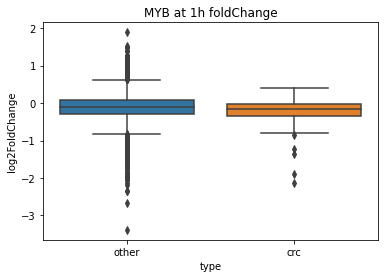

In [424]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("MYB at 1h foldChange")
#ax.figure.savefig('../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersMYB_1h_logfch.pdf")

Text(0.5, 1.0, 'MYB 1h baseMean')

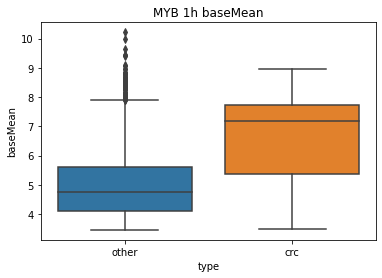

In [425]:
ax =sns.boxplot(data=res,x='type',y='baseMean')
ax.set_title("MYB 1h baseMean")
#ax.figure.savefig('../results/'+project+"/plots/"+project+"_"+scaling+"_whiskers_MYB_1h_baseMean.pdf")

### scatter plot comparison

In [426]:
mix = pd.DataFrame()
mix["gene_id"] = resMYB["gene_id"]
mix['MYB 1h'] = resMYB.log2FoldChange

In [390]:
scatter(mix[['Mybi 30mn','Mybi 6h']].values[:12000], 
               mix['gene_id'].values.tolist()[:12000], radi= 0.06, alpha=0.3,
              colors = [0 if i in ctf else 1 for i in mix['gene_id'].values.tolist()[:12000]],
       xname="Mybi 30mn",
        yname="Mybi 6h",
       folder='../results/'+project+"/plots/"+version+"_"+scaling+"_",
       title='Mybi 30mn vs 6h differences in logFoldChange')

Figure(id='5724', ...)

### volcano plots

In [528]:
resMYB.to_csv("../results/"+project+"/"+project+'_'+scaling+"_"+
              str(minvar_toremove)+'_'+str(mincount_toremove)+'_MYB_deseq.csv')

print("Saved DESeq results to: {}".format("../results/"+project+"/"+project+'_'+scaling+"_"+
              str(minvar_toremove)+'_'+str(mincount_toremove)+'_MYB_deseq.csv'))

Saved DESeq results to: ../results/MYB_degraded_YKL_v1/MYB_degraded_YKL_v1_ERCCsamplewise_0_5_MYB_deseq.csv


In [535]:
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
5,4.308691,0.080422,0.252230,-0.318844,0.749845,0.958100,AARS1,AARS1,other
10,5.273960,-0.056717,0.200152,0.283369,0.776894,0.962462,ABL1,ABL1,other
12,5.050274,0.178466,0.207485,-0.860139,0.389712,0.883798,ABL2,ABL2,other
15,3.634018,-0.279293,0.347547,0.803613,0.421621,0.896113,ACAA1,ACAA1,other
25,5.301423,0.181997,0.195500,-0.930931,0.351889,0.864111,ACLY,ACLY,other


we can conclude that we get similar results to the slamseq myc paper although it seems that our values are a bit skewed toward higher expression than what is on the slamseq paper. It mightt be explained by the pseudo count of 1 that I did not set. Because I think it would highly bias the DESeq algorithm.

In [533]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resMYB, tohighlight=crc, searchbox=True, 
                   title='MV411 MYB dTAG degraded YKL', 
                   folder=volcano_folder)

../results/MYB_degraded_YKL_v1/plots/MYB_degraded_YKL_v1_ERCCsamplewise_0_5


Column(id='6717', ...)

#### testing volcano function

RuntimeError: To use bokeh.io image export functions you need selenium ('conda install selenium' or 'pip install selenium')

<br>RuntimeError: Neither firefox and geckodriver nor a variant of chromium browser and chromedriver are available on system PATH. You can install the former with 'conda install -c conda-forge firefox geckodriver'.

In [486]:
from selenium import webdriver

In [485]:
os.path.dirname(sys.executable)

'/home/monika/anaconda3/envs/slamseq/bin'

In [488]:
from selenium.webdriver.chrome.options import Options

In [491]:
driver_path = "/home/monika/anaconda3/envs/slamseq/bin/chromedriver"

In [492]:
browser = webdriver.Chrome(driver_path)

WebDriverException: Message: unknown error: cannot find Chrome binary


In [506]:
genepyPlot.volcano(resMYB, tohighlight=crc, searchbox=True, 
                   title='DESeq results of MV411 under MYB degraded YKL in volcano plot', 
                   folder=volcano_folder)

Column(id='5075', ...)

In [482]:
os.path.dirname(sys.executable)

'/home/monika/anaconda3/envs/slamseq/bin'

In [513]:
p = bokeh.plotting.figure(title='DESeq results of MV411 under MYB degraded YKL in volcano plot', 
                          plot_width=650, plot_height=450)

In [445]:
type(p)

bokeh.plotting.figure.Figure

In [514]:
def selector(df, valtoextract=[], logfoldtohighlight=0.15, pvaltohighlight=0.1, minlogfold=0.15, minpval=0.1):
    """Part of Volcano plot: A function to separate tfs from everything else"""
    toshow = (df.pvalue < minpval) & (abs(df.log2FoldChange) > minlogfold)
    df = df[toshow]
    sig = (df.pvalue < pvaltohighlight) & (
        abs(df.log2FoldChange) > logfoldtohighlight)
    if valtoextract:
        not_tf = (~df.gene_id.isin(valtoextract))
        is_tf = (df.gene_id.isin(valtoextract))
        to_plot_not = df[~sig | not_tf]
        to_plot_yes = df[sig & is_tf]
    else:
        to_plot_not = df[~sig]
        to_plot_yes = df[sig]
    return to_plot_not, to_plot_yes

In [515]:
# pdb.set_trace()
tohighlight = crc
to_plot_not, to_plot_yes = selector(resMYB, tohighlight if tohighlight is not None else [], 
                                    logfoldtohighlight=0.15, pvaltohighlight=0.1)
hover = bokeh.models.HoverTool(tooltips=[('gene', '@gene_id')], names=['circles'])

In [516]:
# Create figure
p = bokeh.plotting.figure(title='DESeq results of MV411 under MYB degraded YKL in volcano plot', 
                          plot_width=650, plot_height=450, output_backend="svg")

In [517]:
p.xgrid.grid_line_color = 'white'
p.ygrid.grid_line_color = 'white'
p.xaxis.axis_label = 'log-fold change'
p.yaxis.axis_label = '-log(Q)'

In [518]:
def add_points(p, df1, x, y, color='blue', alpha=0.2, outline=False, maxvalue=100):
    """parts of volcano plot"""
    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    df = df1.copy()
    transformed_q = -df[y].apply(np.log10).values
    transformed_q[transformed_q == np.inf] = maxvalue
    df['transformed_q'] = transformed_q
    df['color'] = color
    df['alpha'] = alpha
    df['size'] = 7
    source1 = bokeh.models.ColumnDataSource(df)

    # Specify data source
    p.scatter(x=x, y='transformed_q', size='size',
              alpha='alpha', source=source1,
              color='color', name='circles')
    if outline:
        p.scatter(x=x, y='transformed_q', size=7, alpha=1,
                  source=source1, color='black',
                  fill_color=None, name='outlines')

    # prettify
    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    return p, source1

In [519]:
# Add the hover tool
p.add_tools(hover)
p, source1 = add_points(p, to_plot_not, 'log2FoldChange','pvalue', 
                        color='#1a9641', maxvalue=100)
p, source2 = add_points(p, to_plot_yes, 'log2FoldChange', 'pvalue',
                        color='#fc8d59', alpha=0.6, outline=True, maxvalue=100)

In [520]:
# Searchbox
text = bokeh.models.widgets.TextInput(title="text", value="gene")
text.js_on_change('value', bokeh.models.CustomJS(args=dict(source=source1), 
                                    code="""
                                    var data = source.data
                                    var value = cb_obj.value
                                    var gene_id = data.gene_id
                                    var a = -1
                                    for (i=0; i < gene_id.length; i++) {
                                        if ( gene_id[i]===value ) { a=i; console.log(i); data.size[i]=7; data.alpha[i]=1; data.color[i]='#fc8d59' }
                                    }
                                    source.data = data
                                    console.log(source)
                                    console.log(cb_obj)
                                    source.change.emit()
                                    console.log(source)
                                    """))
p = bokeh.layouts.column(text, p)


In [524]:
volcano_folder
volcano_file = volcano_folder + " DESeq results of MV411 under MYB-dTAG in volcano plot".replace(' ', "_") + "_volcano.html"
volcano_file

'../results/MYB_degraded_YKL_v1/plots/MYB_degraded_YKL_v1_ERCCsamplewise_0_5_DESeq_results_of_MV411_under_MYB-dTAG_in_volcano_plot_volcano.html'

In [526]:
save(p, volcano_file)

'/home/monika/AMLproject/results/MYB_degraded_YKL_v1/plots/MYB_degraded_YKL_v1_ERCCsamplewise_0_5_DESeq_results_of_MV411_under_MYB-dTAG_in_volcano_plot_volcano.html'

In [523]:
show(p)

## DESESEQ w/o ERCC scaling

In [237]:
scaling = None # unscaled

In [782]:
# MYB degraded YKL
tccountsMYB = tccounts[tccounts.columns[:-1]]
print(tccountsMYB.shape)
designMYB = pd.DataFrame(index= [i.replace('-','.') for i in tccountsMYB.columns], 
                         columns=['DMSO','VHL'], 
                         data=np.array([[1,1,1,1,1,1,0,0,0,0,0,0],
                                        [0,0,0,0,0,0,1,1,1,1,1,1]],dtype=bool).T)
designMYB

(16588, 12)


,DMSO,VHL
mr359.MV411.MYB.dTAG.DMSO_1h.r1_tcount,True,False
mr360.MV411.MYB.dTAG.DMSO_1h.r2_tcount,True,False
mr361.MV411.MYB.dTAG.DMSO_1h.r3_tcount,True,False
mr362.MV411.MYB.dTAG.DMSO_1h.r4_tcount,True,False
mr363.MV411.MYB.dTAG.DMSO_1h.r5_tcount,True,False
mr364.MV411.MYB.dTAG.DMSO_1h.r6_tcount,True,False
mr365.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,True
mr366.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,True
mr367.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,True
mr368.MV411.MYB.dTAG.VHL_1h.r4_tcount,False,True


In [238]:
designMYB

,DMSO,VHL
mr359.MV411.MYB.dTAG.DMSO_1h.r1_tcount,True,False
mr360.MV411.MYB.dTAG.DMSO_1h.r2_tcount,True,False
mr361.MV411.MYB.dTAG.DMSO_1h.r3_tcount,True,False
mr362.MV411.MYB.dTAG.DMSO_1h.r4_tcount,True,False
mr363.MV411.MYB.dTAG.DMSO_1h.r5_tcount,True,False
mr364.MV411.MYB.dTAG.DMSO_1h.r6_tcount,True,False
mr365.MV411.MYB.dTAG.VHL_1h.r1_tcount,False,True
mr366.MV411.MYB.dTAG.VHL_1h.r2_tcount,False,True
mr367.MV411.MYB.dTAG.VHL_1h.r3_tcount,False,True
mr368.MV411.MYB.dTAG.VHL_1h.r4_tcount,False,True


In [766]:
tccounts[list(tccountsMYB.columns)+['genes']].iloc[:1]

,mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount,mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount,mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount,genes
0,0,0,0,1,0,0,0,0,0,0,0,0,A1BG


In [784]:
tccountsMYB = tccounts[list(tccountsMYB.columns)+['genes']] # same as original tccounts

MYB_1h = [1] * int(len(list(tccountsMYB.columns))-1) # change if multiple time points
MYB_1h

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [252]:
# readcounts
readcountsMYB = readcounts[['genes']+list(readcounts.columns)[:-1]]
# tccounts
tccountsMYB = tccounts[['genes']+list(tccounts.columns)[:-1]] # same as original tccounts

MYB_1h = [1] * int(len(list(tccountsMYB.columns))-1) # change if multiple time points
MYB_1h

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [261]:
# tccounts
deseqMYB_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsMYB[tccountsMYB.columns[np.array([1]+MYB_1h, bool)]], 
                                design_matrix=designMYB[np.array(MYB_1h, bool)],
                                design_formula="~DMSO - VHL",
                                gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [768]:
# tccounts
deseqMYB_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsMYB[tccountsMYB.columns[np.array(MYB_1h+[1], bool)]], 
                                design_matrix=designMYB[np.array(MYB_1h, bool)],
                                design_formula="~DMSO - VHL",
                                gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.1.0


In [262]:
# readcounts
deseqMYB_read = pyDESeq2.pyDESeq2(count_matrix=readcountsMYB[readcountsMYB.columns[np.array([1]+MYB_1h, bool)]], 
                                design_matrix=designMYB[np.array(MYB_1h, bool)],
                                design_formula="~DMSO - VHL",
                                gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [770]:
# tccounts
deseqMYB_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsMYB.columns[np.array([1,1,1,1,1,1,0,0,0,0,0,0,0], bool)]].values+1), 1)))

In [264]:
# tccounts
deseqMYB_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsMYB.columns[np.array([0]+MYB_DMSO, bool)]].values+1), 1)))

In [265]:
# readcounts
deseqMYB_read.run_estimate_size_factors()

__run DESeq__

In [772]:
# tccounts
deseqMYB_tc.run_deseq()
deseqMYB_tc.get_deseq_result()

resMYB_tc = deseqMYB_tc.deseq_result
resMYB_tc.pvalue = np.nan_to_num(np.array(resMYB_tc.pvalue), 1)
resMYB_tc.log2FoldChange = np.nan_to_num(np.array(resMYB_tc.log2FoldChange), 0)
resMYB_tc.log2FoldChange = -resMYB_tc.log2FoldChange
resMYB_tc["gene_id"] = resMYB_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [266]:
# tccounts
deseqMYB_tc.run_deseq()
deseqMYB_tc.get_deseq_result()

resMYB_tc = deseqMYB_tc.deseq_result
resMYB_tc.pvalue = np.nan_to_num(np.array(resMYB_tc.pvalue), 1)
resMYB_tc.log2FoldChange = np.nan_to_num(np.array(resMYB_tc.log2FoldChange), 0)
resMYB_tc.log2FoldChange = -resMYB_tc.log2FoldChange
resMYB_tc["gene_id"] = resMYB_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [787]:
# readcounts
deseqMYB_read.run_deseq()
deseqMYB_read.get_deseq_result()

resMYB_read = deseqMYB_read.deseq_result
resMYB_read.pvalue = np.nan_to_num(np.array(resMYB_read.pvalue), 1)
resMYB_read.log2FoldChange = np.nan_to_num(np.array(resMYB_read.log2FoldChange), 0)
resMYB_read.log2FoldChange = -resMYB_read.log2FoldChange
resMYB_read["gene_id"] = resMYB_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [267]:
# readcounts
deseqMYB_read.run_deseq()
deseqMYB_read.get_deseq_result()

resMYB_read = deseqMYB_read.deseq_result
resMYB_read.pvalue = np.nan_to_num(np.array(resMYB_read.pvalue), 1)
resMYB_read.log2FoldChange = np.nan_to_num(np.array(resMYB_read.log2FoldChange), 0)
resMYB_read.log2FoldChange = -resMYB_read.log2FoldChange
resMYB_read["gene_id"] = resMYB_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [268]:
resMYB_read.iloc[:5]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.011041,0.114505,0.980153,-0.116824,0.907000,NaN,A1BG,A1BG
1,5.371438,-0.178186,0.478116,0.372684,0.709383,NaN,A2MP1,A2MP1
2,60.352238,0.118616,0.156408,-0.758372,0.448228,0.999857,NAT1,NAT1
3,2.315617,-0.678436,0.748257,0.906689,0.364571,NaN,AADAC,AADAC
4,353.555726,-0.025167,0.074933,0.335860,0.736977,0.999857,AAMP,AAMP


In [788]:
resMYB_read.iloc[:5]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.011058,0.114597,0.980114,-0.116922,0.906922,NaN,A1BG,A1BG
1,5.371370,-0.178186,0.477972,0.372795,0.709301,NaN,A2MP1,A2MP1
2,60.351412,0.118656,0.156367,-0.758833,0.447953,0.999815,NAT1,NAT1
3,2.315576,-0.678435,0.748054,0.906933,0.364442,NaN,AADAC,AADAC
4,353.552380,-0.025143,0.074923,0.335587,0.737182,0.999815,AAMP,AAMP


__Save DESeq results__

In [774]:
scaling = None # unscaled
cond = "1h"
res_dir = "slamseq_{}".format(project)

In [269]:
if scaling:
    print("scaling")
else:
    print("No scaling")

No scaling


In [687]:
# tccounts
deseq_res_file = "{}_deseq_tccounts.csv".format("_".join(filter(None, [project, scaling, str(minvar_toremove), 
                                                                      str(mincount_toremove)])))
resMYB_tc.to_csv("../results/{}/{}".format(project, deseq_res_file), index=False)

print("Saved DESeq results to: ../results/{}/{}".format(project, deseq_res_file))

Saved DESeq results to: ../results/MYB_degraded_YKL_v1/MYB_degraded_YKL_v1_0_5_deseq_tcounts.csv


In [270]:
# tccounts
deseq_res_file = "{}_deseq_tccounts.csv".format("_".join(filter(None, [project, scaling, str(minvar_toremove), 
                                                                      str(mincount_toremove), cond])))
resMYB_tc.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_v1_0_5_1h_deseq_tccounts.csv


In [688]:
# readcounts
deseq_res_file = "{}_deseq_readcounts.csv".format("_".join(filter(None, [project, scaling, str(minvar_toremove), 
                                                                         str(mincount_toremove)])))
resMYB_read.to_csv("../results/{}/{}".format(project, deseq_res_file), index=False)

print("Saved DESeq results to: ../results/{}/{}".format(project, deseq_res_file))

Saved DESeq results to: ../results/MYB_degraded_YKL_v1/MYB_degraded_YKL_v1_0_5_deseq_readcounts.csv


In [271]:
# readcounts
deseq_res_file = "{}_deseq_readcounts.csv".format("_".join(filter(None, [project, scaling, str(minvar_toremove), 
                                                                      str(mincount_toremove), cond])))

resMYB_read.to_csv("../results/{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_v1_0_5_1h_deseq_readcounts.csv


In [272]:
resMYB_tc.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.058330,-0.499954,3.116540,0.160420,0.872550,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,5.267484,0.666676,0.567723,-1.174299,0.240275,0.748709,NAT1,NAT1
3,0.000000,-0.000000,NaN,NaN,0.000000,NaN,AADAC,AADAC
4,9.852382,0.296884,0.338782,-0.876329,0.380851,0.845086,AAMP,AAMP


In [273]:
resMYB_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.011041,0.114505,0.980153,-0.116824,0.907000,NaN,A1BG,A1BG
1,5.371438,-0.178186,0.478116,0.372684,0.709383,NaN,A2MP1,A2MP1
2,60.352238,0.118616,0.156408,-0.758372,0.448228,0.999857,NAT1,NAT1
3,2.315617,-0.678436,0.748257,0.906689,0.364571,NaN,AADAC,AADAC
4,353.555726,-0.025167,0.074933,0.335860,0.736977,0.999857,AAMP,AAMP


# Get all counts (unfiltered)

### Looking for TNF

In [44]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [6]:
project = "MYB_degraded_v1"
res_folder = "res_v4"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v4/count/


In [46]:
# remove genes that have very low counts
mincount_toremove=0

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

In [47]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 12 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount', 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount', 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount', 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount', 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount', 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount', 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount', 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount', 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount', 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount', 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount', 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
mr360-MV411-MYB-dTAG-DMSO_1h-r2
mr361-MV411-MYB-dTAG-DMSO_1h-r3
mr362-MV411-MYB-dTAG-DMSO_1h-r4
mr363-MV411-MYB-dTAG-DMSO_1h-r5
mr364-MV411-MYB-dTAG-DMSO_1h-r6
mr365-MV411-MYB-dTAG-VHL_1h-r1
mr366-MV411-MYB-dTAG-VHL_1h-r2
mr367-MV411-MYB-dTAG-VHL_1h-r3
mr368-MV411-MYB-dTAG-VHL_1h-r4
mr369-MV411-MYB-dTAG-VHL_1h-r5
mr370-MV411-MYB-dTAG-VHL_1h-r6
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
d

In [48]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

Duplicate gene rows!
25420 rows | 25353 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
25420 rows | 25353 unique genes
Summing of duplicate gene rows.


In [51]:
len(duplicate_genes)

67

In [53]:
print(readcounts.index.tolist() == tccounts.index.tolist())
gene_list = readcounts.index.tolist()
len(gene_list)

True


25353

In [54]:
"TNF" in gene_list

True

In [55]:
readcounts.loc["TNF",:]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    0
mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount    0
mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount    0
mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount    0
mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount    0
mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount    0
mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount     0
mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount     1
mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount     0
mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount     0
mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount     0
mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount     0
Name: TNF, dtype: int64

In [56]:
tccounts.loc["TNF",:]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    0
mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount    0
mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount    0
mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount    0
mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount    0
mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount    0
mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount     0
mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount     0
mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount     0
mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount     0
mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount     0
mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount     0
Name: TNF, dtype: int64

In [112]:
readcounts.sum(axis=1).idxmax()

'MALAT1'

In [117]:
tccounts.loc["MYC",:]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    282
mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount    262
mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount    397
mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount    490
mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount    255
mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount    342
mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount      97
mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount     151
mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount     100
mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount      57
mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount      35
mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount      85
Name: MYC, dtype: int64

In [162]:
readcounts.sum(axis=1)

A1BG              22
A2M               13
A2MP1             70
NAT1             733
NAT2               0
                ... 
BOLA2-SMG1P6      39
107303344       1982
SCARNA18B         36
107399301          0
107399303          0
Length: 25353, dtype: int64

In [72]:
folder = "../../data/"+"slamseq_"+project+"/res_v4/map"
files = ! ls $folder/*
files = [file.split('/')[-1] for file in files if file.endswith(".bam") and "sorted" not in file]

In [83]:
files[4:]

['mr363-MV411-MYB-dTAG-DMSO_1h-r5_slamdunk_mapped.bam',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_slamdunk_mapped.bam',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1_slamdunk_mapped.bam',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2_slamdunk_mapped.bam',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3_slamdunk_mapped.bam',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4_slamdunk_mapped.bam',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5_slamdunk_mapped.bam',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6_slamdunk_mapped.bam']

In [96]:
# sort bams
h.parrun(["samtools sort -o "+folder+"/"+os.path.splitext(f)[0]+".sorted"+
          os.path.splitext(f)[1]+" "+folder+"/"+f for f in files[4:]], cores=10)

In [98]:
# index bams
h.parrun(["samtools index "+folder+"/"+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files[4:]], 
         cores=10)

Save to bucket

In [101]:
project_dir = "slamseq_"+project
project_dir

'slamseq_MYB_degraded_v1'

In [103]:
! gsutil -m cp ../../data/$project_dir/res_v4/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 

Copying file://../../data/slamseq_MYB_degraded_v1/res_v4/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/slamseq_MYB_degraded_v1/res_v4/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log [Content-Type=application/octet-stream]...
Co

In [7]:
project

'MYB_degraded_v1'

In [12]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res/map/*mr359*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


In [11]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res/filter/*mr359*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.log


In [13]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v5/map/*mr359*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v5/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v5/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v5/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v5/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


In [14]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v7/map/*mr359*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


In [163]:
! gsutil ls gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam.bed
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/ERCC_mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degrade

In [164]:
! gsutil ls gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.sorted.bam.bai
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/

# Get filtered reads

In [124]:
project = "MYB_degraded_v1"
res_folder = "res_v4"
project_dir = "slamseq_"+project
location= "../../data/"+project_dir+"/"+res_folder+"/"+"filter"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v4/filter


In [131]:
# total filtered counts
# (fill in project manually)
#totalcounts = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [
    60731223, # mr359-MV411-MYB-dTAG-DMSO_1h-r1
    57555769, # mr360-MV411-MYB-dTAG-DMSO_1h-r2
    63165913, # mr361-MV411-MYB-dTAG-DMSO_1h-r3
    74057024, # mr362-MV411-MYB-dTAG-DMSO_1h-r4
    36159435, # mr363-MV411-MYB-dTAG-DMSO_1h-r5
    41235698, # mr364-MV411-MYB-dTAG-DMSO_1h-r6

    53170075, # mr365-MV411-MYB-dTAG-VHL_1h-r1
    69939746, # mr366-MV411-MYB-dTAG-VHL_1h-r2
    53100231, # mr367-MV411-MYB-dTAG-VHL_1h-r3
    58055539, # mr368-MV411-MYB-dTAG-VHL_1h-r4
    39596120, # mr369-MV411-MYB-dTAG-VHL_1h-r5
    65022423, # mr370-MV411-MYB-dTAG-VHL_1h-r6
]

In [125]:
# get filter logs
files = ! ls $location/*
files = [file for file in files if file.endswith(".log")]

In [126]:
files

['../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.log',
 '../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.log',
 '../../data/slamseq_MYB

In [171]:
sample_names = [file.split('/')[-1].split("_1")[0] for file in files]

In [175]:
filtered_reads = [pd.read_csv(file, sep="\t", comment="#").iloc[:,1].sum() for file in files]
pre_filtered_reads = [x+y for x,y in zip(totalcounts, filtered_reads)]

In [176]:
perc_removed = [filt / pre_filt * 100 for filt, pre_filt in zip(filtered_reads, pre_filtered_reads)]
perc_removed = [round(per, 2) for per in perc_removed]

In [177]:
df = pd.DataFrame(list(zip(pre_filtered_reads, totalcounts, filtered_reads, perc_removed)),
                  index=sample_names, columns=["prefilt_reads", "total_filtered_reads", 
                                               "removed_reads", "perc_removed"])
df

,prefilt_reads,total_filtered_reads,removed_reads,perc_removed
mr359-MV411-MYB-dTAG-DMSO,74751702,60731223,14020479,18.76
mr360-MV411-MYB-dTAG-DMSO,71012757,57555769,13456988,18.95
mr361-MV411-MYB-dTAG-DMSO,78471680,63165913,15305767,19.50
mr362-MV411-MYB-dTAG-DMSO,92425611,74057024,18368587,19.87
mr363-MV411-MYB-dTAG-DMSO,44786967,36159435,8627532,19.26
mr364-MV411-MYB-dTAG-DMSO,51395701,41235698,10160003,19.77
mr365-MV411-MYB-dTAG-VHL,65989700,53170075,12819625,19.43
mr366-MV411-MYB-dTAG-VHL,87178928,69939746,17239182,19.77
mr367-MV411-MYB-dTAG-VHL,65862010,53100231,12761779,19.38
mr368-MV411-MYB-dTAG-VHL,71847840,58055539,13792301,19.20


In [179]:
# average % reads removed
round(df['perc_removed'].mean(), 2)

19.44

In [ ]:
74,751,702 # mapped
63,304,285 # filtered

5,964,731 # ID
5,482,686 # MM
11,447,417 # filtered out

In [236]:
14020479-(5964731+5482686)

2573062

In [233]:
round((5964731+5482686)/74751702*100, 2)

15.31

# Rerun slamdunk filtering and all

The 100bp filtered step seems to have messed up the filtered and filtered too many reads from specific genes, like TNF.

Try refiltering at a much higher value to understand if more.

__slamdunk filter inputs__
<br>bam = bams file(s)
<br>-o = output dir for mapped & filtered BAM files
<br>-b = bed file
<br>-mq = min mapping quality
<br>-mi = min alignment identity
<br>-nm = max nm for alignments
<br>-t = threads

input bams: map/  _slamdunk_mapped.bam
<br>bed: gene_intervals
<br>-mq: 2 (default)
<br>-mq (identity): 0.95 (default)
<br>-nm: -1 (default)
<br>-o: res_v4/filter

slamdunk filter NOT run on bed file b/c multimap = False
bed file/gene intervals only used for tcount

__use res_v4__
<br>res_v1 = initial slamdunk all run
 - snp_old: .vcf files empty
 - snp: vcf files filled

<br>res_v2 = manual slamdunk map run on mr359-MV411-MYB-dTAG-DMSO_1h-r1
<br>res_v3 = slamdunk all on mr359-MV411-MYB-dTAG-DMSO_1h-r1
<br>res_v4 = slamdunk all w/ max-read-length = 152 (-rl 152)
<br>res_v5 = slamdunk all w/ (-fb, -m, -n 1, -rl 152)
<br>res_v6 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -mv 0.2)

In [106]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome="../../ref/Homo_sapiens_assembly38_ERCC92.fasta"

In [107]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

In [188]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastqs[:2]

['mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz',
 'mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']

In [189]:
fastq_full = [fastq_folder+"/"+f for f in fastqs]
fastq_full[:2]

['../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz',
 '../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']

In [195]:
for val1, val2 in h.grouped(fastq_full[:2], 2):
    print(val1)
    print(val2)
    print("\n")

../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz




__res_v5__
<br>res_v5 = slamdunk all w/ (-fb, -m, -n 1, -rl 152)

In [196]:
res_dir = "../../data/"+"slamseq_"+project+"/res_v5/"
res_dir

'../../data/slamseq_MYB_degraded_v1/res_v5/'

In [200]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 100'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_v1/res_v5/ -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -c 2 -t 14 -rl 152 -5 12 -n 100 -m -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 175 µs


In [202]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[:2], 2)], 2)

CPU times: user 264 ms, sys: 80 ms, total: 344 ms
Wall time: 2h 25min 10s


counts

In [ ]:
74,751,702 # mapped
63,304,285 # filtered
5,964,731 # ID
5,482,686 # MM

In [ ]:
# sort bams
h.parrun(["samtools sort -o "+folder+"/"+os.path.splitext(f)[0]+".sorted"+
          os.path.splitext(f)[1]+" "+folder+"/"+f for f in files[4:]], cores=10)

# index bams
h.parrun(["samtools index "+folder+"/"+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files[4:]], 
         cores=10)

__Save test sample to bucket__

In [ ]:
project_dir = "slamseq_"+project
project_dir

In [222]:
! gsutil -m cp -r ../../data/$project_dir/res_v5/ gs://amlproject/RNA/slamseq/$project/res_test/

Copying file://../../data/slamseq_MYB_degraded_v1/res_v5/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v5/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v5/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v5/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v5/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" va

In [230]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_test/filter

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.log


In [231]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_test/map

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


In [243]:
! gsutil -m mv gs://amlproject/RNA/slamseq/$project/res_test/ gs://amlproject/RNA/slamseq/$project/res_v5/

Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_test/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying gs://amlproject/RNA/slamseq/MYB_degraded_v1

__Checking counts__

In [203]:
project = "MYB_degraded_v1"
res_folder = "res_v5"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v5/count/


In [204]:
# remove genes that have very low counts
mincount_toremove=0

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

In [205]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 1 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
CPU times: user 43.2 s, sys: 60 ms, total: 43.3 s
Wall time: 1min 42s


In [206]:
print(readcounts.index.tolist() == tccounts.index.tolist())
gene_list = readcounts.index.tolist()
len(gene_list)

True


25420

In [214]:
readcounts.idxmax()

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    RPL13AP5
dtype: object

In [215]:
readcounts.loc['RPL13AP5',:]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    63751
Name: RPL13AP5, dtype: int64

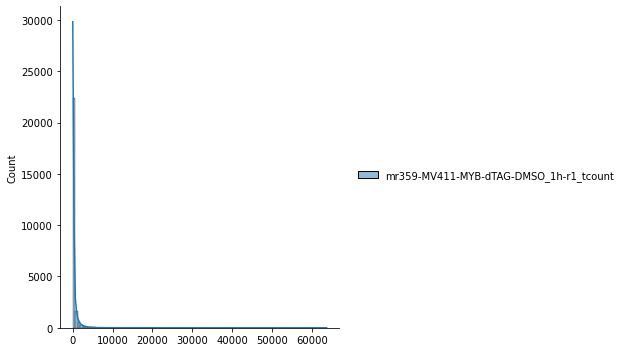

In [220]:
sns.displot(readcounts, bins=100, kde=True)

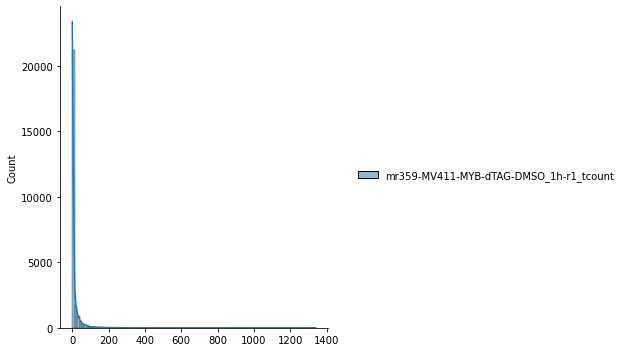

In [221]:
sns.displot(tccounts, bins=100, kde=True)

__res_v6__
<br>res_v6 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -mv 0.2)

In [237]:
res_dir = "../../data/"+"slamseq_"+project+"/res_v6/"
res_dir

'../../data/slamseq_MYB_degraded_v1/res_v6/'

In [238]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -mv 0.2' + # min variant fraction
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_v1/res_v6/ -r ../../ref/Homo_sapiens_assembly38_ERCC92.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 100 -m -mv 0.2 -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 203 µs


In [241]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          ' -mv 0.2' + # minimum variant fraction to call variant
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[:2], 2)], 2)

CPU times: user 268 ms, sys: 80 ms, total: 348 ms
Wall time: 2h 25min 56s


### Make mapped bams & bami for IGV

In [257]:
files = ! ls $res_dir/map/*.bam
files

['../../data/slamseq_MYB_degraded_v1/res_v6//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam']

In [259]:
["samtools sort -o "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1]+
 " "+f for f in files]

['samtools sort -o ../../data/slamseq_MYB_degraded_v1/res_v6//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam ../../data/slamseq_MYB_degraded_v1/res_v6//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam']

In [260]:
["samtools index "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files]

['samtools index ../../data/slamseq_MYB_degraded_v1/res_v6//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam']

In [261]:
# sort bams
h.parrun(["samtools sort -o "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1]+" "+f for f in files], 
         cores=10)

# index bams
h.parrun(["samtools index "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files], 
         cores=10)

In [262]:
project_dir = "slamseq_"+project
project_dir

'slamseq_MYB_degraded_v1'

In [263]:
! gsutil -m cp -r ../../data/$project_dir/res_v6/ gs://amlproject/RNA/slamseq/$project/

Copying file://../../data/slamseq_MYB_degraded_v1/res_v6/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v6/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v6/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v6/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v6/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" va

In [285]:
# original map
! gsutil ls gs://amlproject/RNA/slamseq/$project/res/map/mr359*sorted*bam*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


In [282]:
# original filter
! gsutil ls gs://amlproject/RNA/slamseq/$project/res/filter/mr359*bam*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai


In [291]:
# res_v5 filter
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v5/filter/mr359*bam*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v5/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v5/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai


In [274]:
# res_v6 filter
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v6/filter/*.bam*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v6/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v6/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai


## Read counts

In [292]:
project = "MYB_degraded_v1"
project_dir = "slamseq_"+project
project_dir

'slamseq_MYB_degraded_v1'

In [306]:
res_folders = ["res_v4", "res_v5", "res_v6"]
locations = ["../../data/"+project_dir+"/"+res_folder+"/" for res_folder in res_folders]
print(locations)

['../../data/slamseq_MYB_degraded_v1/res_v4/', '../../data/slamseq_MYB_degraded_v1/res_v5/', '../../data/slamseq_MYB_degraded_v1/res_v6/']


In [300]:
# get file counts
files = sorted(os.listdir(locations[0]+"map"))
files = [file for file in files if file.endswith(".log")]
files

[]

__mapped counts__

In [327]:
mapped_files = [os.path.join(locations[0]+"map", file) for file in os.listdir(locations[0]+"map")]
mapped_files = [file for file in mapped_files if file.endswith(".bam") & ("sorted" not in file)]
mapped_files

['../../data/slamseq_MYB_degraded_v1/res_v4/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr370-MV411-MYB-dTAG-VHL_1h-r6_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr368-MV411-MYB-dTAG-VHL_1h-r4_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr363-MV411-MYB-dTAG-DMSO_1h-r5_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr364-MV411-MYB-dTAG-DMSO_1h-r6_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr369-MV411-MYB-dTAG-VHL_1h-r5_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr366-MV411-MYB-dTAG-VHL_1h-r2_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr362-MV411-MYB-dTAG-DMSO_1h-r4_slamdunk_mapped.bam',
 '../../data/slamseq_MYB_degraded_v1/res_v4/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdu

In [342]:
! for unkn in $(ls $locations); do echo $unkn; done

bigwig
Cell_lines_WGS_analysis.ipynb
ChIP_analysis_v2
Enrichment
and
Correlation-Copy1.ipynb
CoBinding
Enrichment
and
Correlation.ipynb
CoBinding
Motifs
and
predictions.ipynb
CoBinding
pre-processing
and
analysis.ipynb
creating_intervals_CRISPRtargets.ipynb
Fish_SuperRes.ipynb
JQ1_RNA_analysis-v1.ipynb
JQ1_RNA_analysis-v2.ipynb
JQ1_RNAseq_processing.ipynb
MONOMAC1_synergistic_MEF2D-C.ipynb
multipage.pdf
MV411_RNP_MEIS1.ipynb
predictd
Processing_ChipSeq.ipynb
Processing_differential_binding.ipynb
Processing_differential_binding-mo.ipynb
Processing_differential_binding
part2.ipynb
Processing_differential_binding
part3.ipynb
Processing_slamseq.ipynb
python_refresh.ipynb
RNA_RNP_analysis.ipynb
Slamseq
analysis.ipynb
slamseq_iBet_muhar_paper_additionnals.ipynb
slamseq_iBet_muhar_paper.ipynb
slamseq_iBet_spikeIn_maxp_paper.ipynb
slamseq_iBet_spikeIn_maxp_paper-READCOUNTS.ipynb
slamseq_IRF2BP2_degraded_v1_spikeIn.ipynb
Slamseq
IRF2BP2
degraded
v2.ipynb
slamseq_MV411_YLKinhib.ipynb
slamseq_MYB

In [343]:
# get only mapped(primary aligned) reads
# (fill in project manually)
totalcounts = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v4/map/*_mapped.bam); do samtools view -c -F 260 $unkn; done
totalcounts

['74751702',
 '71012757',
 '78471680',
 '92425611',
 '44786967',
 '51395701',
 '65989700',
 '87178928',
 '65862010',
 '71847840',
 '48708610',
 '81956479']

In [344]:
totalcounts_mapped = [int(i) for i in totalcounts]

In [361]:
# samples in totalcounts order
samples = [f.split("/")[6].rsplit("_", 2)[0] for f in mapped_files]
samples.sort()

In [362]:
samples

['mr359-MV411-MYB-dTAG-DMSO_1h-r1',
 'mr360-MV411-MYB-dTAG-DMSO_1h-r2',
 'mr361-MV411-MYB-dTAG-DMSO_1h-r3',
 'mr362-MV411-MYB-dTAG-DMSO_1h-r4',
 'mr363-MV411-MYB-dTAG-DMSO_1h-r5',
 'mr364-MV411-MYB-dTAG-DMSO_1h-r6',
 'mr365-MV411-MYB-dTAG-VHL_1h-r1',
 'mr366-MV411-MYB-dTAG-VHL_1h-r2',
 'mr367-MV411-MYB-dTAG-VHL_1h-r3',
 'mr368-MV411-MYB-dTAG-VHL_1h-r4',
 'mr369-MV411-MYB-dTAG-VHL_1h-r5',
 'mr370-MV411-MYB-dTAG-VHL_1h-r6']

__res_v4__

In [368]:
ls ../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr*.bam

../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr361-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr362-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr363-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr364-MV411-MYB-dTAG-DMSO_1h-r6_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr365-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr366-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr367-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr368-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam
../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr369-MV411-MYB

In [369]:
# get only mapped(primary aligned) reads
# (fill in project manually)
filtercounts_resv4 = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v4/filter/mr*.bam); do samtools view -c -F 260 $unkn; done


In [370]:
filtercounts_resv4 = [int(i) for i in filtercounts_resv4]

In [371]:
# get only mapped(primary aligned) reads
# (fill in project manually)
filtercounts_resv5 = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v5/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
filtercounts_resv5 = [int(i) for i in filtercounts_resv5]


In [372]:
# get only mapped(primary aligned) reads
# (fill in project manually)
filtercounts_resv6 = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v6/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
filtercounts_resv6 = [int(i) for i in filtercounts_resv6]


In [373]:
filtercounts_resv4

[60731223,
 57555769,
 63165913,
 74057024,
 36159435,
 41235698,
 53170075,
 69939746,
 53100231,
 58055539,
 39596120,
 65022423]

In [374]:
filtercounts_resv5

[63304285]

In [375]:
filtercounts_resv6

[63304294]

In [376]:
mr359_filtercounts = [filtercounts_resv4[0], filtercounts_resv5[0], filtercounts_resv6[0]]
mr359_filtercounts

[60731223, 63304285, 63304294]

In [385]:
totalcounts_mapped[0]

74751702

In [382]:
counts_removed = [totalcounts_mapped[0]-i for i in mr359_filtercounts]
counts_removed

[14020479, 11447417, 11447408]

In [386]:
per_rem = [remv/totalcounts_mapped[0]*100 for remv in counts_removed]
per_rem = [round(per, 2) for per in per_rem]
per_rem

[18.76, 15.31, 15.31]

# Remove alternate references from ref hg38 fasta

alternative locations
<br>alternate contig

In [389]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome="../../ref/Homo_sapiens_assembly38_ERCC92.fasta"

In [388]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

In [387]:
# google storage bucket with reference files
! gsutil ls gs://ccle_default_params/

gs://ccle_default_params/1000g_pon.hg38.vcf.gz
gs://ccle_default_params/1000g_pon.hg38.vcf.gz.tbi
gs://ccle_default_params/3UTRs.bed
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf.idx
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters.json
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters_light.json
gs://ccle_default_params/CNV_and_centromere_blacklist.hg38liftover.list
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bai
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bam
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta.fai
gs://ccle_default_params/STAR

In [390]:
! ls ../../ref

alt_fastq_IDs.txt
ERCC92.fa
ERCC92.gtf
GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed
hg38_ERCC92.gtf
Homo_sapiens_assembly38_ERCC92.fasta
Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
Homo_sapiens_assembly38_ERCC92.fasta.fai
Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
reference_droso.fna


In [391]:
# read in ERCC pseudocounts
ref = pd.read_csv(refgenome, sep=" ", header=None)

ParserError: Too many columns specified: expected 13 and found 1

In [392]:
f = open(refgenome)

In [394]:
lines = f.readlines()
lines = [l.strip() for l in lines]

In [398]:
alt_refs = [line for line in lines if "_alt" in line]

In [401]:
sequences = []
for line in lines:
    if ">" in line:
        sequences.append([])
    sequences[-1].append(line)

In [407]:
for seq in sequences[190:200]:
    print(seq[0])

>chrUn_GL000214v1  AC:GL000214.1  gi:224183298  LN:137718  rl:unplaced  M5:46c2032c37f2ed899eb41c0473319a69  AS:GRCh38
>chrUn_KI270742v1  AC:KI270742.1  gi:568335255  LN:186739  rl:unplaced  M5:2f31c013a4a8301deb8ab7ed1ca1cd99  AS:GRCh38
>chrUn_GL000216v2  AC:GL000216.2  gi:568335254  LN:176608  rl:unplaced  M5:725009a7e3f5b78752b68afa922c090c  AS:GRCh38
>chrUn_GL000218v1  AC:GL000218.1  gi:224183305  LN:161147  rl:unplaced  M5:1d708b54644c26c7e01c2dad5426d38c  AS:GRCh38
>chr1_KI270762v1_alt  AC:KI270762.1  gi:568335926  LN:354444  rg:chr1:2448811-2791270  rl:alt-scaffold  M5:b0397179e5a92bb7a3300b68e45a9f72  AS:GRCh38
>chr1_KI270766v1_alt  AC:KI270766.1  gi:568335924  LN:256271  rg:chr1:13075113-13312803  rl:alt-scaffold  M5:e3f36479d0e07abbd0d47babdc76e19d  AS:GRCh38
>chr1_KI270760v1_alt  AC:KI270760.1  gi:568335927  LN:109528  rg:chr1:30352191-30456601  rl:alt-scaffold  M5:f2ea4b127c54df13f53a2b2b5a358087  AS:GRCh38
>chr1_KI270765v1_alt  AC:KI270765.1  gi:568335920  LN:185285  rg:ch

In [408]:
alt_sequences = []
for seq in sequences:
    if any(line in alt_refs for line in seq):
        alt_sequences.append(seq)

In [411]:
norm_sequences = [seq for seq in sequences if seq not in alt_sequences]

In [414]:
norm_lines = [item for sublist in norm_sequences for item in sublist]

In [418]:
ref_no_alt = "../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [419]:
f_noAlt = open(ref_no_alt, "w")
for line in norm_lines:
    f_noAlt.write(line+"\n")
f_noAlt.close()

# Rerun SLAMDUNK w/ no alt (test)

In [4]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [5]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

In [6]:
project = "MYB_degraded_v1"

In [10]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]

In [9]:
fastq_full = [fastq_folder+"/"+f for f in fastqs]
fastq_full[:2]

['../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz',
 '../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']

In [11]:
for val1, val2 in h.grouped(fastq_full[:2], 2):
    print(val1)
    print(val2)
    print("\n")

../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz




## res_v7

__res_v7__
<br>res_v7 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

In [7]:
res_dir = "../../data/"+"slamseq_"+project+"/res_v7/"
res_dir

'../../data/slamseq_MYB_degraded_v1/res_v7/'

In [424]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       #' -mv 0.2' + # min variant fraction
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_v1/res_v7/ -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -mv 0.2 -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 190 µs


In [425]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          #' -mv 0.2' + # minimum variant fraction to call variant
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[:2], 2)], 2)

CPU times: user 264 ms, sys: 208 ms, total: 472 ms
Wall time: 2h 32min 36s


In [426]:
files = ! ls $res_dir/map/*.bam
files

['../../data/slamseq_MYB_degraded_v1/res_v7//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam']

In [427]:
print(["samtools sort -o "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1]+
 " "+f for f in files])

print(["samtools index "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files])

['samtools sort -o ../../data/slamseq_MYB_degraded_v1/res_v7//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam ../../data/slamseq_MYB_degraded_v1/res_v7//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam']
['samtools index ../../data/slamseq_MYB_degraded_v1/res_v7//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam']


In [428]:
# sort bams
h.parrun(["samtools sort -o "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1]+" "+f for f in files], 
         cores=10)

# index bams
h.parrun(["samtools index "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files], 
         cores=10)

In [429]:
project_dir = "slamseq_"+project
project_dir

'slamseq_MYB_degraded_v1'

In [430]:
! gsutil -m cp -r ../../data/$project_dir/res_v7 gs://amlproject/RNA/slamseq/$project/

Copying file://../../data/slamseq_MYB_degraded_v1/res_v7/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v7/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v7/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v7/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" va

In [434]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v7/filter/*bam*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai


In [435]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v7/map/*sorted*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v7/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


## res_v8

__res_v8__ : __no multimapping__
<br>res_v8 = slamdunk all w/ (-fb, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

In [471]:
res_dir = "../../data/"+"slamseq_"+project+"/res_v8/"
res_dir

'../../data/slamseq_MYB_degraded_v1/res_v8/'

In [472]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       #' -m'+ # multimapping
       #' -mv 0.2' + # min variant fraction
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_v1/res_v8/ -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -N mr359-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 183 µs


In [473]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          #' -m'+ # multimapping
          #' -mv 0.2' + # minimum variant fraction to call variant
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[:2], 2)], 2)

CPU times: user 260 ms, sys: 192 ms, total: 452 ms
Wall time: 2h 20min 14s


In [474]:
files = ! ls $res_dir/map/*.bam
files

['../../data/slamseq_MYB_degraded_v1/res_v8//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam']

In [475]:
print(["samtools sort -o "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1]+
 " "+f for f in files])

print(["samtools index "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files])

['samtools sort -o ../../data/slamseq_MYB_degraded_v1/res_v8//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam ../../data/slamseq_MYB_degraded_v1/res_v8//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam']
['samtools index ../../data/slamseq_MYB_degraded_v1/res_v8//map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam']


In [476]:
# sort bams
h.parrun(["samtools sort -o "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1]+" "+f for f in files], 
         cores=10)

# index bams
h.parrun(["samtools index "+os.path.splitext(f)[0]+".sorted"+os.path.splitext(f)[1] for f in files], 
         cores=10)

In [477]:
project_dir = "slamseq_"+project
project_dir

'slamseq_MYB_degraded_v1'

In [478]:
! gsutil -m cp -r ../../data/$project_dir/res_v8 gs://amlproject/RNA/slamseq/$project/

Copying file://../../data/slamseq_MYB_degraded_v1/res_v8/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v8/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v8/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v8/count/mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount_plus.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_v1/res_v8/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" va

In [479]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v8/filter/*bam*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v8/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v8/filter/mr359-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam.bai


In [480]:
! gsutil ls gs://amlproject/RNA/slamseq/$project/res_v8/map/*sorted*

gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v8/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam
gs://amlproject/RNA/slamseq/MYB_degraded_v1/res_v8/map/mr359-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.sorted.bam.bai


## Read counts

<br>res_v1 = initial slamdunk all run
 - snp_old: .vcf files empty
 - snp: vcf files filled

<br>res_v2 = manual slamdunk map run on mr359-MV411-MYB-dTAG-DMSO_1h-r1 # removed
<br>res_v3 = slamdunk all on mr359-MV411-MYB-dTAG-DMSO_1h-r1
<br>res_v4 = slamdunk all w/ max-read-length = 152 (-rl 152)
<br>res_v5 = slamdunk all w/ (-fb, -m, -n 1, -rl 152)
<br>res_v6 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -mv 0.2) # don't need
<br>res_v7 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)
<br>res_v8 = slamdunk all w/ (-fb, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

In [439]:
project = "MYB_degraded_v1"
project_dir = "slamseq_"+project
project_dir

'slamseq_MYB_degraded_v1'

In [440]:
res_folders = ["res_v4", "res_v5", "res_v6", "res_v7"]
locations = ["../../data/"+project_dir+"/"+res_folder+"/" for res_folder in res_folders]
print(locations)

['../../data/slamseq_MYB_degraded_v1/res_v4/', '../../data/slamseq_MYB_degraded_v1/res_v5/', '../../data/slamseq_MYB_degraded_v1/res_v6/', '../../data/slamseq_MYB_degraded_v1/res_v7/']


### Mapped reads

In [441]:
mapped_res = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_v1/res_v4/map/*.sorted.bam); do samtools view -c -F 260 $unkn; done
mapped_res

^C


[]

In [481]:
mapped_reads = {'res_v4': 74751702, # old run
                'res_v5': 74751702, # multimapped
                'res_v6': 74751702, # -mv 0.2
                'res_v7': 74736415, # no alt
                'res_v8': 74736415} # no alt, not multimapped

In [453]:
print("mapped reads lost: "+str(mapped_reads['res_v4'] - mapped_reads['res_v7']))
print("% mapped reads lost: "+str(round((mapped_reads['res_v4'] - mapped_reads['res_v7']) 
                                        / mapped_reads['res_v4'] * 100, 5)))

mapped reads lost: 15287
% mapped reads lost: 0.02045


In [448]:
(mapped_reads['res_v4'] - mapped_reads['res_v7']) / mapped_reads['res_v4'] * 100

0.020450370481196536

### Filtered reads

In [482]:
filtered_reads = {'res_v4': 60731223, # old run
                  'res_v5': 63304285, # multimapped
                  'res_v6': 63304294, # -mv 0.2
                  'res_v7': 64600920, # no alt
                  'res_v8': 62236919} # no alt, not multimapped

In [464]:
print("Added from multimapped reads: "+str(filtered_reads['res_v5'] - filtered_reads['res_v4']))
print("Added from multimapped & -mv 0.2: "+str(filtered_reads['res_v6'] - filtered_reads['res_v4']))
print("Added from no alt refs: "+str(filtered_reads['res_v7'] - filtered_reads['res_v4']))

Added from multimapped reads: 2573062
Added from multimapped & -mv 0.2: 2573071
Added from no alt refs: 3869697


In [496]:
print((64600920 - 62236919))
print(round((64600920 - 62236919)/mapped_reads['res_v7'] * 100, 2))

2364001
3.16


In [461]:
print("Added from multimapped & -mv 0.2: "+str(filtered_reads['res_v6'] - filtered_reads['res_v4']))

Added from multimapped & -mv 0.2: 2573071


In [462]:
print("Added from no alt refs: "+str(filtered_reads['res_v7'] - filtered_reads['res_v4']))

Added from no alt refs: 3869697


In [484]:
print("Percent of reads filtered out res_v4: "+
      str(round((mapped_reads['res_v4']-filtered_reads['res_v4'])/mapped_reads['res_v4']*100, 2)))
print("Percent of reads filtered out res_v5: "+
      str(round((mapped_reads['res_v5']-filtered_reads['res_v5'])/mapped_reads['res_v5']*100, 2)))
print("Percent of reads filtered out res_v6: "+
      str(round((mapped_reads['res_v6']-filtered_reads['res_v6'])/mapped_reads['res_v6']*100, 2)))
print("Percent of reads filtered out res_v7: "+
      str(round((mapped_reads['res_v7']-filtered_reads['res_v7'])/mapped_reads['res_v7']*100, 2)))
print("Percent of reads filtered out res_v8: "+
      str(round((mapped_reads['res_v8']-filtered_reads['res_v8'])/mapped_reads['res_v8']*100, 2)))

Percent of reads filtered out res_v4: 18.76
Percent of reads filtered out res_v5: 15.31
Percent of reads filtered out res_v6: 15.31
Percent of reads filtered out res_v7: 13.56
Percent of reads filtered out res_v8: 16.72


__Removing alternate loci__
* less mapped reads
* more filtered reads (relative and total)

# Get slamdunk counts

In [498]:
# remove genes that have very low counts
mincount_toremove=0

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

__res_v4__

In [497]:
project = "MYB_degraded_v1"
res_folder = "res_v4"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v4/count/


In [499]:
%%time

# all genes (not just protein coding)
readcounts_resv4, tccounts_resv4 = rna.readFromSlamdunk(loc=location, 
                                                        minvar_toremove=minvar_toremove, 
                                                        mincount_toremove=mincount_toremove,
                                                        verbose=False)

found 12 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount', 'mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount', 'mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount', 'mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount', 'mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount', 'mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount', 'mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount', 'mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount', 'mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount', 'mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount', 'mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount', 'mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
mr360-MV411-MYB-dTAG-DMSO_1h-r2
mr361-MV411-MYB-dTAG-DMSO_1h-r3
mr362-MV411-MYB-dTAG-DMSO_1h-r4
mr363-MV411-MYB-dTAG-DMSO_1h-r5
mr364-MV411-MYB-dTAG-DMSO_1h-r6
mr365-MV411-MYB-dTAG-VHL_1h-r1
mr366-MV411-MYB-dTAG-VHL_1h-r2
mr367-MV411-MYB-dTAG-VHL_1h-r3
mr368-MV411-MYB-dTAG-VHL_1h-r4
mr369-MV411-MYB-dTAG-VHL_1h-r5
mr370-MV411-MYB-dTAG-VHL_1h-r6
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
d

__res_v5__

In [507]:
project = "MYB_degraded_v1"
res_folder = "res_v5"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v5/count/


In [508]:
%%time

# all genes (not just protein coding)
readcounts_resv5, tccounts_resv5 = rna.readFromSlamdunk(loc=location, 
                                                        minvar_toremove=minvar_toremove, 
                                                        mincount_toremove=mincount_toremove,
                                                        verbose=False)

found 1 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
CPU times: user 45.5 s, sys: 36 ms, total: 45.6 s
Wall time: 1min 56s


__res_v7__

In [500]:
project = "MYB_degraded_v1"
res_folder = "res_v7"
location= "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_v1/res_v7/count/


In [501]:
%%time

# all genes (not just protein coding)
readcounts_resv7, tccounts_resv7 = rna.readFromSlamdunk(loc=location, 
                                                        minvar_toremove=minvar_toremove, 
                                                        mincount_toremove=mincount_toremove,
                                                        verbose=False)

found 1 files:dict_keys(['mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount'])
mr359-MV411-MYB-dTAG-DMSO_1h-r1
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
CPU times: user 50.8 s, sys: 28 ms, total: 50.9 s
Wall time: 1min 57s


In [504]:
readcounts_resv4.loc['TNF',]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    0
mr360-MV411-MYB-dTAG-DMSO_1h-r2_tcount    0
mr361-MV411-MYB-dTAG-DMSO_1h-r3_tcount    0
mr362-MV411-MYB-dTAG-DMSO_1h-r4_tcount    0
mr363-MV411-MYB-dTAG-DMSO_1h-r5_tcount    0
mr364-MV411-MYB-dTAG-DMSO_1h-r6_tcount    0
mr365-MV411-MYB-dTAG-VHL_1h-r1_tcount     0
mr366-MV411-MYB-dTAG-VHL_1h-r2_tcount     1
mr367-MV411-MYB-dTAG-VHL_1h-r3_tcount     0
mr368-MV411-MYB-dTAG-VHL_1h-r4_tcount     0
mr369-MV411-MYB-dTAG-VHL_1h-r5_tcount     0
mr370-MV411-MYB-dTAG-VHL_1h-r6_tcount     0
Name: TNF, dtype: int64

In [509]:
readcounts_resv5.loc['TNF',]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    61
Name: TNF, dtype: int64

In [506]:
readcounts_resv7.loc['TNF',]

mr359-MV411-MYB-dTAG-DMSO_1h-r1_tcount    398
Name: TNF, dtype: int64

In [510]:
print(readcounts_resv4.sum(axis=1).idxmax())
print(readcounts_resv5.sum(axis=1).idxmax())
print(readcounts_resv7.sum(axis=1).idxmax())

MALAT1
RPL13AP5
RPL13AP5


In [ ]:
print(readcounts_resv.loc[readcounts_resv4.sum(axis=1).idxmax(),:])

# Rerun SLAMDUNK w/ no alt (full)

In [4]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [5]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

In [6]:
project = "MYB_degraded_v1"

In [7]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]

In [8]:
fastq_full = [fastq_folder+"/"+f for f in fastqs]
fastq_full[:2]

['../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz',
 '../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz']

In [9]:
for val1, val2 in h.grouped(fastq_full[:2], 2):
    print(val1)
    print(val2)
    print("\n")

../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz




<br>res_v1 = initial slamdunk all run __# removed__
 - snp_old: .vcf files empty
 - snp: vcf files filled

<br>res_v2 = manual slamdunk map run on mr359-MV411-MYB-dTAG-DMSO_1h-r1 __# removed__
<br>res_v3 = slamdunk all on mr359-MV411-MYB-dTAG-DMSO_1h-r1 __# removed__
<br>res_v4 = slamdunk all w/ max-read-length = 152 (-rl 152)
<br>res_v5 = slamdunk all w/ (-fb, -m, -n 1, -rl 152)
<br>res_v6 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -mv 0.2) __# removed__
<br>res_v7 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)
<br>res_v8 = slamdunk all w/ (-fb, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

## res_v7

In [10]:
res_dir = "../../data/"+"slamseq_"+project+"/res_v7/"
res_dir

'../../data/slamseq_MYB_degraded_v1/res_v7/'

__res_v7__
<br>res_v7 = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

In [11]:
for idx, vals in enumerate(h.grouped(fastq_full, 2)):
    print(idx)
    print(vals[0])
    print(vals[1])

0
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz
1
../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001_val_2.fq.gz
2
../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz
3
../../data/slamseq_MYB_degraded_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001_val_2.fq.gz
4
../../data/slamseq_MYB_degraded_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_val_2.fq.gz
5
../../data/slamseq_MYB_degraded_v1/fastqs/mr364-MV411-MYB-

In [530]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[2:], 2)], 2)

ValueError: issue with the command: b'[MAIN] [MAIN] NextGenMap 0.5.5\n[MAIN] NextGenMap 0.5.5Startup : x64 (build Jul  3 2020 02:47:43)\n\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2021-10-25.18:16:21[MAIN] \nStarting time: 2021-10-25.18:16:21\n[CONFIG] [CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_MYB_degraded_v1/res_v7/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.sam --overwrite 1 --pair_score_cutoff 0.900000 --paired 1 --parse_all 1 --pe_delimiter / --qry1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz --qry2 ../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001_val_2.fq.gz --qry_count -1 --qry_start 0 --ref ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta --ref_mode -1 --rg_id 0 --rg_sm sample_0:NA:-1 --sensitive 0 --silent_clip 0 --skip_mate_check 0 --skip_save 0 --slam_seq 2 --step_count 4 --strata 0 --topn 1 --trim5 12 --update_check 0 --very_fast 0 --very_sensitive 0Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.000000 --mismatch_penalty 15 --mode 0 --no_progress 1 --no_unal 0 --ocl_threads 1 --output ../../data/slamseq_MYB_degraded_v1/res_v7/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.sam --overwrite 1 --pair_score_cutoff 0.900000 --paired 1 --parse_all 1 --pe_delimiter / --qry1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz --qry2 ../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz --qry_count -1 --qry_start 0 --ref ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta --ref_mode -1 --rg_id 0 --rg_sm sample_0:NA:-1 --sensitive 0 --silent_clip 0 --skip_mate_check 0 --skip_save 0 --slam_seq 2 --step_count 4 --strata 0 --topn 1 --trim5 12 --update_check 0 --very_fast 0 --very_sensitive 0\n\n[NGM] [NGM] Opening for output (SAM): ../../data/slamseq_MYB_degraded_v1/res_v7/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.samOpening for output (SAM): ../../data/slamseq_MYB_degraded_v1/res_v7/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.sam\n\n[SEQPROV] [SEQPROV] Reading encoded reference from ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta-enc.2.ngmReading encoded reference from ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta-enc.2.ngm\n\n[SEQPROV] [SEQPROV] Reading 3111 Mbp from disk took 10.17sReading 3111 Mbp from disk took 10.17s\n\n[PREPROCESS] [PREPROCESS] Reading RefTable from ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta-ht-13-2.3.ngmReading RefTable from ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta-ht-13-2.3.ngm\n\n[PREPROCESS] [PREPROCESS] Reading from disk took 29.96sReading from disk took 29.96s\n\n[PREPROCESS] Max. k-mer frequency set so 887!\n[INPUT] Input is paired end data.\n[INPUT] Opening file ../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz for reading\n[INPUT] Opening file ../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001_val_2.fq.gz for reading\n[PREPROCESS] Max. k-mer frequency set so 887!\n[INPUT] Input is paired end data.\n[INPUT] Opening file ../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz for reading\n[INPUT] Opening file ../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz for reading\n[INPUT] Input is Fastq\n[INPUT] Estimating parameter from data\n[INPUT] Input is Fastq\n[INPUT] Estimating parameter from data\n[INPUT] Input reads don\'t have the same length!\n[INPUT] Maximum read length found in the first 10000000 reads is 138. For longer reads only the first 151 bp will be mapped.\n[INPUT] The maximum read length can be overwritten with the \'--max-read-length\' parameter. With \'--force-rlength-check\', NextGenMap will run through all reads to find the max. read length. This might take some time.\n[INPUT] Average read length: 123 (min: 8, max: 152)\n[INPUT] Corridor width: 23\n[INPUT] Average kmer hits pro read: 26.144913\n[INPUT] Max possible kmer hit: 37\n[INPUT] Estimated sensitivity: 0.706619\n[INPUT] Estimating parameter took 37.652s\n[INPUT] Input is Fastq\n[INPUT] Input is Fastq\n[INPUT] Input reads don\'t have the same length!\n[INPUT] Maximum read length found in the first 10000000 reads is 138. For longer reads only the first 151 bp will be mapped.\n[INPUT] The maximum read length can be overwritten with the \'--max-read-length\' parameter. With \'--force-rlength-check\', NextGenMap will run through all reads to find the max. read length. This might take some time.\n[INPUT] Average read length: 127 (min: 8, max: 152)\n[INPUT] Corridor width: 24\n[INPUT] Average kmer hits pro read: 27.274818\n[INPUT] Max possible kmer hit: 38\n[INPUT] Estimated sensitivity: 0.717758\n[INPUT] Estimating parameter took 38.838s\n[INPUT] Input is Fastq\n[INPUT] Input is Fastq\n[OPENCL] [OPENCL] Available platforms: 1Available platforms: 1\n\n[OPENCL] [OPENCL] AMD Accelerated Parallel ProcessingAMD Accelerated Parallel Processing\n\n[OPENCL] [OPENCL] Selecting OpenCl platform: AMD Accelerated Parallel ProcessingSelecting OpenCl platform: AMD Accelerated Parallel Processing\n\n[OPENCL] [OPENCL] Platform: OpenCL 1.2 AMD-APP (1214.3)Platform: OpenCL 1.2 AMD-APP (1214.3)\n\n[OPENCL] [OPENCL] 1 CPU device found.1 CPU device found.\n\n[OPENCL] [OPENCL] Device 0: Intel(R) Xeon(R) CPU (Driver: 1214.3 (sse2,avx))Device 0: Intel(R) Xeon(R) CPU (Driver: 1214.3 (sse2,avx))\n\n[OPENCL] [OPENCL] 8 CPU cores available.8 CPU cores available.\n\nException bad_alloc occured in thread 9. This usually means you ran out of physical or virtual memory (try ulimit -v)\nSegmentation fault\nslamdunk all\nRunning slamDunk map for 2 files (14 threads)\nTraceback (most recent call last):\n  File "/home/monika/anaconda3/envs/slamseq/bin/slamdunk", line 33, in <module>\n    sys.exit(load_entry_point(\'slamdunk\', \'console_scripts\', \'slamdunk\')())\n  File "/home/monika/slamdunk/slamdunk/slamdunk.py", line 540, in run\n    runAll(args)\n  File "/home/monika/slamdunk/slamdunk/slamdunk.py", line 254, in runAll\n    runMap(tid, samples[0], referenceFile, n, args.trim5, args.maxPolyA, args.quantseq,\n  File "/home/monika/slamdunk/slamdunk/slamdunk.py", line 160, in runMap\n    mapper.Map(inputBAM1, referenceFile, outputSAM, getLogFile(outputLOG), quantseqMapping, endtoendMapping, inputBAM2=inputBAM2, threads=threads, trim5p=trim5p,\n  File "/home/monika/slamdunk/slamdunk/dunks/mapper.py", line 113, in Map\n    run("ngm -r " + inputReference + compute_on + " -t " + str(threads) + " " + parameter + " -o " + outputSAM, log, verbose=verbose, dry=printOnly)\n  File "/home/monika/slamdunk/slamdunk/utils/misc.py", line 208, in run\n    raise RuntimeError("Error while executing command (or pressed leave)\\\nRuntimeError: Error while executing command (or pressed leave)                : "ngm -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -1 ../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz -2 ../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz -t 14 --no-progress --slam-seq 2 -5 12 --max-polya 4 -l  --rg-id 0 --rg-sm sample_0:NA:-1 -o ../../data/slamseq_MYB_degraded_v1/res_v7/map/mr361-MV411-MYB-dTAG-DMSO_1h-r3_slamdunk_mapped.sam"\n[MAIN] Valid pairs found: 74.77%\n[MAIN] Estimated insert size: 222 bp\n[MAIN] Alignments computed: 76849115\n[MAIN] Done (70999057 reads mapped (90.49%), 7464967 reads not mapped (630 discarded), 78463394 lines written)(elapsed: 3941.174805s)\n[UPDATE_CHECK] Your version of NGM is more than 6 months old - a newer version may be available. (For performing an automatic check use --update-check)\nslamdunk all\nRunning slamDunk map for 2 files (14 threads)\n.\nRunning slamDunk sam2bam for 1 files (14 threads)\n.\nRunning slamDunk filter for 1 files (14 threads)\n[E::idx_find_and_load] Could not retrieve index file for \'../../data/slamseq_MYB_degraded_v1/res_v7/map/mr360-MV411-MYB-dTAG-DMSO_1h-r2_slamdunk_mapped.bam\'\n[E::idx_find_and_load] Could not retrieve index file for \'../../data/slamseq_MYB_degraded_v1/res_v7/filter/mr360-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam\'\n[bam_sort_core] merging from 33 files and 1 in-memory blocks...\n\n\nRunning slamDunk SNP for 1 files (7 threads)\n\nRunning slamDunk tcount for 1 files (14 threads)\n\n\n...'

rerun fastq_full[4:6] (mr360-MV411-MYB-dTAG-DMSO_1h)

In [17]:
%%time

print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       #' -mv 0.2' + # min variant fraction
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[10:12], 2)])

['slamdunk all -o ../../data/slamseq_MYB_degraded_v1/res_v7/ -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr364-MV411-MYB-dTAG-DMSO_1h-r6 ../../data/slamseq_MYB_degraded_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_v1/fastqs/mr364-MV411-MYB-dTAG-DMSO_1h-r6_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.88 ms


In [18]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(fastq_full[10:12], 2)], 2)

CPU times: user 260 ms, sys: 72 ms, total: 332 ms
Wall time: 2h 26min 40s


In [24]:
for idx, vals in enumerate(h.grouped(fastq_full, 2)):
    print(idx)
    print(vals[0])
    print(vals[1])

0
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr359-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz
1
../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr360-MV411-MYB-dTAG-DMSO_1h-r2_R2_001_val_2.fq.gz
2
../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz
3
../../data/slamseq_MYB_degraded_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001_val_2.fq.gz
4
../../data/slamseq_MYB_degraded_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_val_2.fq.gz
5
../../data/slamseq_MYB_degraded_v1/fastqs/mr364-MV411-MYB-

In [25]:
pending_fastqs = fastq_full[4:10]+fastq_full[12:]

In [28]:
for idx, vals in enumerate(h.grouped(pending_fastqs, 2)):
    print(idx)
    print(vals[0])
    print(vals[1])

0
../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr361-MV411-MYB-dTAG-DMSO_1h-r3_R2_001_val_2.fq.gz
1
../../data/slamseq_MYB_degraded_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr362-MV411-MYB-dTAG-DMSO_1h-r4_R2_001_val_2.fq.gz
2
../../data/slamseq_MYB_degraded_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr363-MV411-MYB-dTAG-DMSO_1h-r5_R2_001_val_2.fq.gz
3
../../data/slamseq_MYB_degraded_v1/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr365-MV411-MYB-dTAG-VHL_1h-r1_R2_001_val_2.fq.gz
4
../../data/slamseq_MYB_degraded_v1/fastqs/mr366-MV411-MYB-dTAG-VHL_1h-r2_R1_001_val_1.fq.gz
../../data/slamseq_MYB_degraded_v1/fastqs/mr366-MV411-MYB-dTAG-VHL_1h-r2_R2_001_val_2.fq.gz
5
../../data/slamseq_MYB_degraded_v1/fastqs/mr367-MV411-MYB-dTAG

In [ ]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2
          for val1, val2 in h.grouped(pending_fastqs, 2)], 2)